In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
import os
import glob
import seaborn as sns
from scipy import stats
import statsmodels.stats.api as sms
import cv2
gait_dir = '/Users/iwoods/Documents/GitHub/gait/'
this_dir = os.getcwd()
os.chdir(gait_dir)
import gaitFunctions
from gaitFunctions import pairwiseStats
import combineClips
import plotClip
os.chdir(this_dir)
def meanstdstr(vals):
    return str(np.round(np.mean(vals),2)) + ' ± ' + str(np.round(np.std(vals),2))

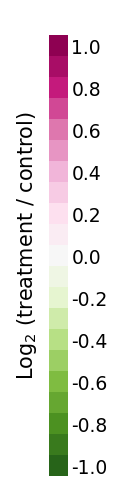

In [2]:
# plot colors and parameters
axis_fontsize=11
tick_fontsize=9

# colors for step kinematics
stance_color = '#5656ff'
swing_color = '#e1e813'
duty_color = '#4d4d4d'
ipsi_color = 'tab:red'
contra_color = 'tab:green'
mcl_color = 'tab:orange'

# colors for legs
first_pair_color = '#bc272d' # red
first_pair_color_alt = '#f77276' # salmon
second_pair_color = '#50a9d4' # teal
second_pair_color_alt = '#95dafc' # sky blue
third_pair_color = '#fa9805' # orange
third_pair_color_alt = '#e9c716' # gold
rear_leg_color = '#a665c9'# violet
rear_leg_color_alt = '#0000a2' # indigo

# scatter marker size and alpha
marker_size = 10
marker_alpha = 0.7
marker_color = 'k'

# control vs. experimental colors
cmap = 'PiYG_r'

def getLevelColor(cmap,level):
    colormap = mpl.colormaps[cmap]
    level_boundaries = np.linspace(-0.95,0.95,20)
    cmap_levels = np.linspace(0,1,21)
    
    for i, boundary in enumerate(level_boundaries):
        if level <= boundary:
            return colormap(cmap_levels[i])
        
    return colormap(cmap_levels[-1])

# vertical map
levels = np.linspace(-1,1,21)
ylevel = 0
f,ax = plt.subplots(figsize=(1,4), dpi=150, facecolor=(1,1,1,0))
for i, level in enumerate(levels):
    square_color = getLevelColor(cmap, level)
    square = patches.Rectangle((0.1, ylevel), 1, 1, linewidth=0.1, edgecolor=None, facecolor=square_color)        
    ax.add_patch(square)
    tenx = int(np.round(level*10,1))
    if tenx % 2 == 0:
        ax.text(1.15,ylevel+0.15,str(np.round(level,1)),fontsize=tick_fontsize)
    ylevel += 1
ax.set_ylabel('Log$_{2}$ (treatment / control)')
ax.set_ylim([0,len(levels)+1])
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.spines.left.set_visible(False)
ax.set_aspect('equal')
ax.set_yticks([])
ax.set_xticks([])
# ax.set_axis_off()

plt.show()

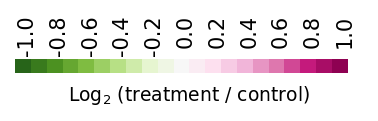

In [3]:
# horizontal map

levels = np.linspace(-1,1,21)
xlevel = 0
f,ax = plt.subplots(figsize=(3,1), dpi=150, facecolor=(1,1,1,0))
for i, level in enumerate(levels):
    square_color = getLevelColor(cmap, level)
    square = patches.Rectangle((xlevel, 0.1), 1, 1, linewidth=0.1, edgecolor=None, facecolor=square_color)        
    ax.add_patch(square)
    tenx = int(np.round(level*10,1))
    if tenx % 2 == 0:
        ax.text(xlevel+0.15,3.8,str(np.round(level,1)), rotation=90, verticalalignment='top')
    xlevel += 1
ax.set_xlabel('Log$_{2}$ (treatment / control)')
ax.set_xlim([0,len(levels)+1])
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.spines.left.set_visible(False)
ax.set_aspect('equal')
ax.set_yticks([])
ax.set_xticks([])
ax.yaxis.label.set_size(tick_fontsize)
ax.xaxis.label.set_size(tick_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
# ax.set_axis_off()

plt.show()

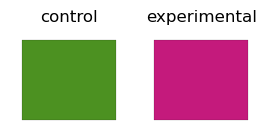

In [4]:
col_level = 0.8
con_color = getLevelColor('PiYG_r', -col_level)
exp_color = getLevelColor('PiYG_r', col_level)
palette = [con_color,exp_color]

f,[ax1,ax2] = plt.subplots(1,2,figsize=(2.8,1.5))
con_square = patches.Rectangle((0.1, 0.1), 0.8, 0.8, linewidth=0.1, edgecolor='k', facecolor=con_color)        
ax1.add_patch(con_square)
ax1.axis('off')
ax1.set_title('control')

exp_square = patches.Rectangle((0.1, 0.1), 0.8, 0.8, linewidth=0.1, edgecolor='k', facecolor=exp_color)        
ax2.add_patch(exp_square)
ax2.axis('off')
ax2.set_title('experimental')

plt.tight_layout()
plt.show()

# Option 1: Select the folders to include in the analysis ... (or see below)

In [5]:
# # navigate to directory that contains the data
# main_dir = '/Users/iwoods/OneDrive - Ithaca College/2024_movement_disorder_paper/videos_disulfiram/'
# os.chdir(main_dir)
# # list directories within this directory
# dirs = []
# for dirname, dirnames, filenames in os.walk('.'):
#     # print path to all subdirectories first.
#     for subdirname in dirnames:
#         folder = os.path.join(dirname, subdirname).split('/')[1]
#         if folder not in dirs:
#             dirs.append(folder)
# dirs = np.sort(np.unique(np.array(dirs)))
# dirs = [x for x in dirs if 'disulfiram' in x.lower()] # change to babies or adults or ramazzottius or disulfiram
# folders_in_analysis = gaitFunctions.selectMultipleFromList(dirs) 

# Option 2: Manually select the folders

In [6]:
# main_dir = '/Users/iwoods/OneDrive - Ithaca College/2024_tardiGait_paper/'
# base_dir = '/Users/iwoods/Library/CloudStorage/OneDrive-IthacaCollege/2024_tardiGait_paper/'
# folders_in_analysis = [base_dir + 'videos_disulfiram/Disulfiram 12Jan24 Inverted',
#                        base_dir + 'videos_disulfiram/Disulfiram 13Dec23 Inverted',
#                        base_dir + 'videos_disulfiram/Disulfiram 16Dec22 Inverted',
#                        base_dir + 'videos_disulfiram/Disulfiram 8Dec22 Inverted',
# ]
# control = 'control'
# experimental = 'disulfiram'

In [7]:
main_dir = '/Users/iwoods/OneDrive - Ithaca College/2024_tardiGait_paper/'
base_dir = '/Users/iwoods/Library/CloudStorage/OneDrive-IthacaCollege/2024_tardiGait_paper/'
folders_in_analysis = [base_dir + 'videos_wild/ramazzottius_14Sep23',
                       base_dir + 'videos_wild/ramazzottius_21Sep23',
                       base_dir + 'videos_exemplaris/iw_11Dec23_exemplaris_inverted',
                       base_dir + 'videos_exemplaris/iw_18Jan24_exemplaris_inverted',
                       base_dir + 'videos_exemplaris/iw_21Dec23_exemplaris_inverted',
                       base_dir + 'videos_exemplaris/iw_9Nov23_exemplaris_inverted',
                       base_dir + 'videos_exemplaris/iw_8Mar24_exemplaris_inverted',
                       base_dir + 'videos_exemplaris/iw_misc_exemplaris'
]
control = 'exemplaris'
experimental = 'ramazzottius'

In [8]:
# main_dir = '/Users/iwoods/OneDrive - Ithaca College/2024_tardiGait_paper/'
# base_dir = '/Users/iwoods/Library/CloudStorage/OneDrive-IthacaCollege/2024_tardiGait_paper/'
# folders_in_analysis = [base_dir + 'videos_babies/babies_Feb2024',
#                        base_dir + 'videos_exemplaris/iw_11Dec23_exemplaris_inverted',
#                        base_dir + 'videos_exemplaris/iw_18Jan24_exemplaris_inverted',
#                        base_dir + 'videos_exemplaris/iw_21Dec23_exemplaris_inverted',
#                        base_dir + 'videos_exemplaris/iw_9Nov23_exemplaris_inverted',
#                        base_dir + 'videos_exemplaris/iw_8Mar24_exemplaris_inverted',
#                        base_dir + 'videos_exemplaris/iw_misc_exemplaris'
# ]
# control = 'adult'
# experimental = 'juvenile'

# Load the data from the selected folders

In [9]:
### in each folder, look for a 'combined' excel file and load (or append) it to a dataframe
# if there is no 'combined' excel file, run combineClips and then load the file
os.chdir(main_dir)

path_summaries_df = pd.DataFrame()
step_timing_df = pd.DataFrame()
step_summaries_df = pd.DataFrame()
gait_summaries_df = pd.DataFrame()
gait_styles_speeds_df = pd.DataFrame()

def appendDF(original,new):
    if len(original) == 0:
        original = new
    else:
        new = pd.concat([original, new])
    return new

for folder in folders_in_analysis:
    os.chdir(folder)
    combined_files = sorted(glob.glob('*combined*xlsx'))
    if len(combined_files) == 0:
        print('Combining .xlsx files in ' + folder)
        pdf, stcdf, sdf, gdf, gssdf = combineClips.main(True)
    elif len(combined_files) == 1:
        excel_file = combined_files[0]
        print('Found ' + combined_files[0])
        
        # read in data from this excel file
        pdf = pd.read_excel(excel_file, sheet_name='path_summaries', index_col=None)
        stdf = pd.read_excel(excel_file, sheet_name='step_timing', index_col=None)
        sdf = pd.read_excel(excel_file, sheet_name='step_summaries', index_col=None)
        gdf = pd.read_excel(excel_file, sheet_name='gait_summaries', index_col=None)
        gssdf = pd.read_excel(excel_file, sheet_name='gait_speeds', index_col=None)
        
        # append to existing dataframe
        path_summaries_df = appendDF(path_summaries_df, pdf)
        step_timing_df = appendDF(step_timing_df, stdf)
        step_summaries_df = appendDF(step_summaries_df, sdf)
        gait_summaries_df = appendDF(gait_summaries_df, gdf)
        gait_styles_speeds_df = appendDF(gait_styles_speeds_df, gssdf)
    else:
        print('Too many "combined" files in ' + folder)
    os.chdir(main_dir)
path_summaries_df.head(5)

Found ramazzottius_14Sep23_combined.xlsx
Found ramazzottius_21Sep23_combined.xlsx
Found iw_11Dec23_exemplaris_inverted_combined.xlsx
Found iw_18Jan24_exemplaris_inverted_combined.xlsx
Found iw_21Dec23_exemplaris_inverted_combined.xlsx
Found iw_9Nov23_exemplaris_inverted_combined.xlsx
Found iw_8Mar24_exemplaris_inverted_combined.xlsx
Found iw_misc_exemplaris_combined.xlsx


,Identifier,treatment,individual,date,Scale (pixels in 1mm),Body Size (mm^2),Body Length (mm),Body Width (mm),Body Width/Length Ratio,Duration analyzed (sec),...,Percentage of time cruising,Speed (mm/sec cruising),Speed (body lengths / sec cruising),Total bearing change (deg),Bearing change (deg) / sec,Bearing change (deg) / sec cruising,Number of stops,Stops / sec,Number of turns,Turns / sec
0,gbf_14sep_tardigrade01_ramazzottius,ramazzottius,tardigrade01,14sep,956.0300,0.018622,0.258572,0.103176,0.399024,144.6061,...,4.673093,NaN,NaN,1084.268267,7.498081,NaN,29,0.200545,10,0.069153
1,hp_14sep_tardigrade01_ramazzottius,ramazzottius,tardigrade01,14sep,956.0300,0.016372,0.239175,0.093667,0.391627,61.3030,...,58.724666,0.060339,0.252280,1980.887867,32.313066,22.174740,14,0.228374,11,0.179437
2,hp_14sep_tardigrade02_ramazzottius,ramazzottius,tardigrade02,14sep,956.0300,0.013376,0.212864,0.088790,0.417120,98.8182,...,34.437289,0.037130,0.174432,2391.306733,24.199052,29.209256,32,0.323827,14,0.141674
3,jc_14sep_tardigrade01_ramazzottius,ramazzottius,tardigrade01,14sep,956.0300,0.012101,0.205943,0.080448,0.390630,104.5757,...,2.463054,NaN,NaN,525.681200,5.026801,NaN,10,0.095625,4,0.038250
4,jc_14sep_tardigrade03_ramazzottius,ramazzottius,tardigrade03,14sep,956.0225,0.010959,0.193571,0.074888,0.386875,82.1819,...,77.617994,0.034471,0.178078,2180.828800,26.536607,17.203796,18,0.219026,9,0.109513


In [10]:
def updateTreatment(df):
    treatments = df.treatment.values
    for i in np.arange(len(treatments)):
        if treatments[i] == 'unknown' or treatments[i] == 'adult':
            treatments[i] = 'exemplaris'
    df['treatment'] = treatments
    return df

if experimental == 'ramazzottius':
    path_summaries_df = updateTreatment(path_summaries_df)
    step_timing_df = updateTreatment(step_timing_df)
    step_summaries_df = updateTreatment(step_summaries_df)
    gait_summaries_df = updateTreatment(gait_summaries_df)
    gait_styles_speeds_df = updateTreatment(gait_styles_speeds_df)
print(gait_summaries_df.treatment.values)

['ramazzottius' 'ramazzottius' 'ramazzottius' 'ramazzottius'
 'ramazzottius' 'ramazzottius' 'ramazzottius' 'ramazzottius'
 'ramazzottius' 'ramazzottius' 'ramazzottius' 'ramazzottius'
 'ramazzottius' 'ramazzottius' 'exemplaris' 'exemplaris' 'exemplaris'
 'exemplaris' 'exemplaris' 'exemplaris' 'exemplaris' 'exemplaris'
 'exemplaris' 'exemplaris' 'exemplaris' 'exemplaris' 'exemplaris'
 'exemplaris' 'exemplaris' 'exemplaris' 'exemplaris' 'exemplaris'
 'exemplaris' 'exemplaris' 'exemplaris' 'exemplaris' 'exemplaris'
 'exemplaris' 'exemplaris' 'exemplaris' 'exemplaris' 'exemplaris'
 'exemplaris' 'exemplaris' 'exemplaris' 'exemplaris' 'exemplaris'
 'exemplaris' 'exemplaris' 'exemplaris' 'exemplaris' 'exemplaris'
 'exemplaris' 'exemplaris' 'exemplaris' 'exemplaris' 'exemplaris'
 'exemplaris' 'exemplaris' 'exemplaris' 'exemplaris' 'exemplaris'
 'exemplaris' 'exemplaris' 'exemplaris' 'exemplaris' 'exemplaris'
 'exemplaris' 'exemplaris' 'exemplaris' 'exemplaris' 'exemplaris'
 'exemplaris' 'exempl

# examine values for a column (e.g. to look for outliers)

Looking at  Body Length (mm)
full set: 127
exemplaris 103 0.25152854289991644
ramazzottius 24 0.22478822352618666


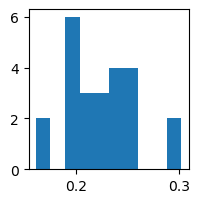

,Identifier,Body Length (mm),treatment
3,jc_14sep_tardigrade01_ramazzottius,0.205943,ramazzottius
7,sp_14sep_tardigrade03_ramazzottius,0.210528,ramazzottius
2,hp_14sep_tardigrade02_ramazzottius,0.212864,ramazzottius
3,jc_21sep_tardigrade03_ramazzottius,0.217721,ramazzottius
9,rm_21sep_tardigrade03_ramazzottius,0.227475,ramazzottius
7,rm_21sep_tardigrade01_ramazzottius,0.227799,ramazzottius
4,jc_21sep_tardigrade04_ramazzottius,0.237268,ramazzottius
1,hp_14sep_tardigrade01_ramazzottius,0.239175,ramazzottius


In [11]:
# col = 'Speed (body lengths / sec cruising)'
col = 'Body Length (mm)'
print('Looking at ', col)
df = path_summaries_df[['Identifier',col,'treatment']]
print('full set:', len(df))
c_vals = df[df['treatment']==control][col].values
c_mean = np.nanmean(c_vals)
print(control, len(c_vals), c_mean)
e_vals = df[df['treatment']!=control][col].values
e_mean = np.nanmean(e_vals)
print(experimental, len(e_vals), e_mean)

# show a histogram for this column
toshow_df = df[df['treatment']==experimental] # experimental or control
f = plt.figure(figsize=(2,2))
a=f.add_axes([0.1,0.1,0.8,0.8])
plt.hist(toshow_df[col].values)
plt.show()

# show a bit of dataframe around halfway point to find 'average' individual
halfpoint = int(len(toshow_df)/2)
buffer = 4
toshow_df.sort_values(by=col).head(halfpoint+buffer).tail(2*buffer) # .head(half + some).tail(some)


In [12]:
treatments = [experimental,control]
for t in treatments:
    vals = df[df['treatment']==t][col].values
    print('max', t, np.max(vals))
    print('mean', t, np.mean(vals))
    print('min', t, np.min(vals))
    print('n',t,'=', len(vals))
    print()

max ramazzottius 0.3019690701895755
mean ramazzottius 0.22478822352618666
min ramazzottius 0.1610359689146263
n ramazzottius = 24

max exemplaris 0.3264368001249307
mean exemplaris 0.25152854289991644
min exemplaris 0.1925400023831821
n exemplaris = 103



# Selecting data to analyze

In [13]:
# Path Data
print(path_summaries_df.columns)
path_cols =[
#     'Body Size (mm^2)', 
    'Body Length (mm)',
#     'Body Width (mm)', 
    'Body Width/Length Ratio', 
#     'Duration analyzed (sec)',
#     'Distance traveled (mm)', 
    'Percentage of time cruising', # this is basically body length / sec, and inverse of stops / sec
#     'Speed (mm/sec)',
    'Speed (body lengths / sec)', 
#     'Speed (mm/sec cruising)', 
    'Speed (body lengths / sec cruising)',
#     'Total bearing change (deg)', 
#     'Bearing change (deg) / sec',
    'Bearing change (deg) / sec cruising', 
#     'Number of stops', 
#     'Stops / sec', # this is basically just the inverse of % cruising
#     'Number of turns', 
#     'Turns / sec'
]
print(len(path_cols))

Index(['Identifier', 'treatment', 'individual', 'date',
       'Scale (pixels in 1mm)', 'Body Size (mm^2)', 'Body Length (mm)',
       'Body Width (mm)', 'Body Width/Length Ratio', 'Duration analyzed (sec)',
       'Distance traveled (mm)', 'Speed (mm/sec)',
       'Speed (body lengths / sec)', 'Percentage of time cruising',
       'Speed (mm/sec cruising)', 'Speed (body lengths / sec cruising)',
       'Total bearing change (deg)', 'Bearing change (deg) / sec',
       'Bearing change (deg) / sec cruising', 'Number of stops', 'Stops / sec',
       'Number of turns', 'Turns / sec'],
      dtype='object')
6


In [14]:
# STEP KINEMATICS
# print(step_summaries_df.columns) # working need to update all of these - rerun analyzeSteps and combineClips
step_cols = [
    'Stance duration (lateral legs)', 
    'Swing duration (lateral legs)',
#     'Gait cycle (lateral legs)', 
#     'Duty factor (lateral legs)',
    'mm per step (lateral legs)', 
    'bodylength per step (lateral legs)',
    'Stance duration (rear legs)', 
    'Swing duration (rear legs)',
#     'Gait cycle (rear legs)', 
#     'Duty factor (rear legs)',
#     'mm per step (rear legs)', 
    'bodylength per step (rear legs)', 
#     'Metachronal lag (lateral legs)',
#     'Metachronal lag (normalized, lateral legs)',
#     'Metachronal lag Abs (Left-Right Ratio)',
#     'Metachronal lag ratios per L3 step', # transformed this to
    'Abs MCL Ratio per L3',
#     'Bearing change per L3 step',
#     'Anterior swing offsets (lateral legs)',
    'Anterior swing offsets (normalized, lateral legs)',
#     'Opposite swing offsets (lateral legs)',
    'Opposite swing offsets (normalized, lateral legs)',
#     'Opposite swing offsets (rear legs)',
    'Opposite swing offsets (normalized, rear legs)']
print(len(step_cols))

11


In [15]:
print(step_summaries_df['Abs MCL Ratio per L3'].values)
print(step_summaries_df['Metachronal lag Abs (Left-Right Ratio)'].values)

[0.424      0.5111734  0.24807547 0.85177453 0.65206839 0.74323319
 0.28463523 0.79401159 0.5475232  0.14447283 0.55105354 0.39865915
 0.40413016 0.29088482 0.40812662 0.72593422 0.44712741 0.4447929
 0.33688388 0.62322493 0.41005094 0.30676576 0.94725302 0.65980104
 0.7579565  0.27935266 0.809063   0.46274754 0.17132932 0.2185225
 0.51165589 0.5923673  0.7226353  0.50642317 0.22843475 0.32067172
 0.53139856 0.30284024 0.88453387 0.47309092 0.2769305  0.37630206
 0.63334279 0.29748808 0.79723698 0.13560538 0.39066247 0.67188389
 0.30673889 0.50066933 0.12837489 0.1576344  0.97900602 0.58662864
 0.6172801  0.65743349 0.3781861  0.19999806 0.23594779 0.1808639
 0.29239659 0.7712189  0.34085281 0.39503752 0.32843667 0.22596851
 0.62764401 0.35696121 0.39252118 0.47673952 0.5435362  0.45058968
 0.52507053 0.42952387 0.47795777 0.54879731 0.52974932 0.61928083
 0.25048862 0.58677536 0.81491675 0.81905078 0.36234683 0.58539228
 0.25724592 0.64968171 0.45891857 0.99872523 0.51470764 0.4141421

In [16]:
# GAIT STYLES
# print(gait_summaries_df.columns)
gait_cols = [
#     '% stand (lateral legs)',
#     '% pentapod (lateral legs)',
    '% tetrapod canonical (lateral legs)',
#     '% tetrapod gallop (lateral legs)', 
#     '% tetrapod other (lateral legs)',
#     '% tetrapod total (lateral legs)', 
    '% tripod canonical (lateral legs)',
#     '% tripod other (lateral legs)', 
#     '% tripod total (lateral legs',
#     '% other (lateral legs)',
#     '% stand (rear legs)', 
#     '% hop (rear legs)',
    '% step (rear legs)',
    'Tetrapod Coordination Strength',
#     'Tetrapod Bout Speed (bodylength / s)',
    'Tripod Coordination Strength',
#     'Tripod Bout Speed (bodylength / s)'
#     'CLR tetrapod canonical (lateral legs)',
#     'CLR tripod canonical (lateral legs)',
#     'CLR step (rear legs)'
]
print(len(gait_cols))

5


# Exploring the data
What are correlations in all data? To see this, merge the dataframes
<br> ... but a problem with merging is that we OMIT anything that does not have step tracking!
<br> ... may need/want to keep these, especially if we are interest in (non-cruising) speed.

In [17]:
def mergeDataframes(dflist,col='Identifier'):
    df = dflist[0].copy()
    for i in np.arange(len(dflist[:-1])):
        df = df.merge(dflist[i+1],on=col)
    return df

def getDfForCol(col, dflist):
    for df in dflist:
        if col in df.columns:
            return df.copy()
    return None

In [18]:
merged_df = mergeDataframes([path_summaries_df, step_summaries_df, gait_summaries_df])
merged_df.columns

Index(['Identifier', 'treatment_x', 'individual_x', 'date_x',
       'Scale (pixels in 1mm)', 'Body Size (mm^2)', 'Body Length (mm)',
       'Body Width (mm)', 'Body Width/Length Ratio', 'Duration analyzed (sec)',
       'Distance traveled (mm)', 'Speed (mm/sec)',
       'Speed (body lengths / sec)', 'Percentage of time cruising',
       'Speed (mm/sec cruising)', 'Speed (body lengths / sec cruising)',
       'Total bearing change (deg)', 'Bearing change (deg) / sec',
       'Bearing change (deg) / sec cruising', 'Number of stops', 'Stops / sec',
       'Number of turns', 'Turns / sec', 'treatment_y', 'individual_y',
       'Stance duration (lateral legs)', 'Swing duration (lateral legs)',
       'Gait cycle (lateral legs)', 'Duty factor (lateral legs)',
       'mm per step (lateral legs)', 'bodylength per step (lateral legs)',
       'Stance duration (rear legs)', 'Swing duration (rear legs)',
       'Gait cycle (rear legs)', 'Duty factor (rear legs)',
       'mm per step (rear legs)'

In [19]:
df = merged_df.copy() # merged_df or path_summaries_df step_summaries_df gait_summaries_df
analysis_cols = ['treatment'] + path_cols + step_cols + gait_cols
df = df[analysis_cols]

In [20]:
df.count()
# df.describe()

treatment                                            117
Body Length (mm)                                     117
Body Width/Length Ratio                              117
Percentage of time cruising                          117
Speed (body lengths / sec)                           117
Speed (body lengths / sec cruising)                  117
Bearing change (deg) / sec cruising                  117
Stance duration (lateral legs)                       117
Swing duration (lateral legs)                        117
mm per step (lateral legs)                           117
bodylength per step (lateral legs)                   117
Stance duration (rear legs)                          117
Swing duration (rear legs)                           117
bodylength per step (rear legs)                      117
Abs MCL Ratio per L3                                 117
Anterior swing offsets (normalized, lateral legs)    116
Opposite swing offsets (normalized, lateral legs)    116
Opposite swing offsets (normali

In [21]:
# change 'treatment' to category datatype, and see how many unique values we have (there should be 2)
for df in [merged_df, path_summaries_df, step_summaries_df, gait_summaries_df]:
    df['treatment'] = df['treatment'].astype('category') 
    df['Condition'] = np.where(df['treatment'] == control, 0, 1) # dummy variable for treatment

merged_df.describe(include='category')

,treatment
count,117
unique,2
top,exemplaris
freq,103


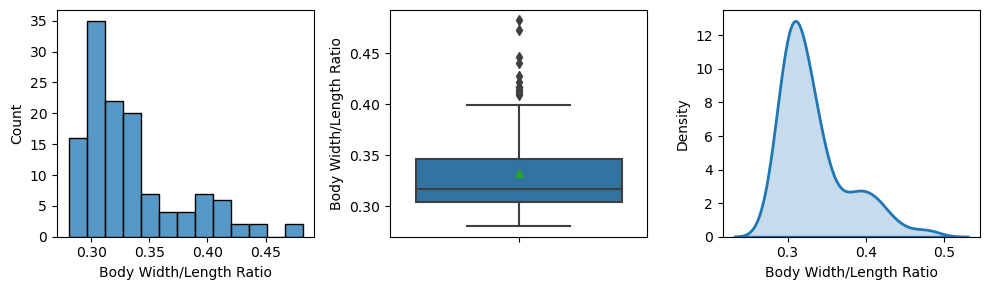

In [22]:
# looking at ALL data for a specified column
col = 'Body Width/Length Ratio'
df = getDfForCol(col, [path_summaries_df, step_summaries_df, gait_summaries_df])
f,[a1,a2,a3] = plt.subplots(1,3,figsize=(10,3))
a1=sns.histplot(ax=a1, x=df[col])
a2=sns.boxplot(ax=a2, y=df[col], showmeans=True)
a3=sns.kdeplot(ax=a3, x=df[col], fill=True, linewidth=2);
plt.tight_layout()
plt.show()

Body Width/Length Ratio


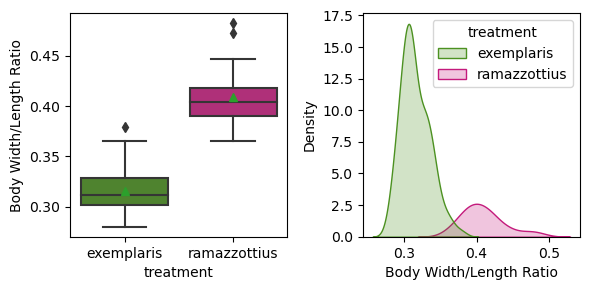

In [23]:
# comparing control vs. treatment for a specified column (col)
f,(a1,a2) = plt.subplots(1,2,figsize=(6,3))
print(col)
df = getDfForCol(col, [path_summaries_df, step_summaries_df, gait_summaries_df])
sns.boxplot(ax=a1, x=df['treatment'], palette=palette, y=df[col], showmeans=True)
sns.kdeplot(ax=a2, x=col, hue='treatment', palette=palette, data=df, fill=True)
plt.tight_layout()
plt.show()

Body Width/Length Ratio


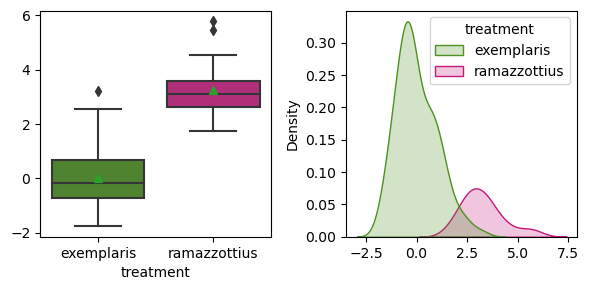

In [24]:
# Converting to ZSCORES (ended up not going in this direction . . . )
f,(a1,a2) = plt.subplots(1,2,figsize=(6,3))
print(col)
conditions = df['Condition'].values
zscores = np.zeros(len(df[col].values))
control_data = df[df['Condition']==0][col].values
exp_data = df[df['Condition']==1][col].values
control_mean = np.nanmean(control_data)
control_std = np.nanstd(control_data)
exp_std = np.nanstd(exp_data)

for i, val in enumerate(df[col].values):
    if conditions[i] == 0: # control
        zscores[i] = (val-control_mean) / control_std
    elif conditions[i] == 1: # exp
        zscores[i] = (val-control_mean) / exp_std

sns.boxplot(ax=a1, x=df['treatment'], y=zscores, palette=palette, showmeans=True)
sns.kdeplot(ax=a2, x=zscores, hue='treatment', palette=palette, data=df, fill=True)
plt.tight_layout()
plt.show()

In [25]:
# T-test using fancy statsmodels
control_data = df[df['Condition']==0][col].values
exp_data = df[df['Condition']==1][col].values
levene=stats.levene(control_data, exp_data)
if levene.pvalue < 0.1:
    var = 'unequal'
    print('unequal variance')
else:
    var = 'pooled'
model = sms.CompareMeans.from_data(control_data, exp_data)
print(model.summary(usevar=var))

unequal variance
                          Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1     -0.0934      0.006    -14.817      0.000      -0.106      -0.080


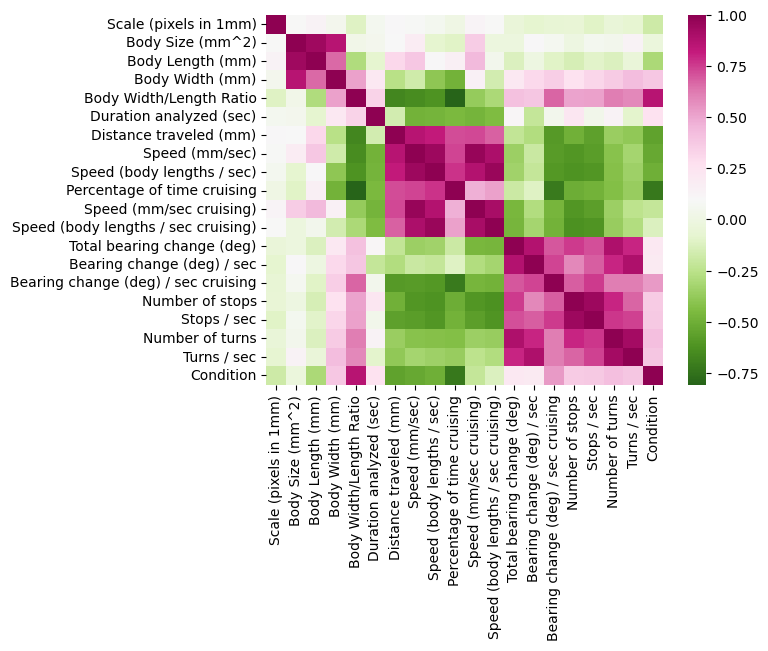

In [26]:
# looking for correlations within the dataset
corrmat = df.corr(numeric_only=True)
sns.heatmap(corrmat,cmap=cmap) # 'bwr' # https://matplotlib.org/stable/users/explain/colors/colormaps.html
plt.show()

# Linear Regression 

In [27]:
# Try a linear regression with X as 'Condition' and Y as a column of interest
import statsmodels.api as sm
col = 'Body Width/Length Ratio'
df = getDfForCol(col, [path_summaries_df, step_summaries_df, gait_summaries_df])
Y = df[col] # col is from above, or reset here
X = df['Condition'] # 
X = sm.add_constant(X)
model = sm.OLS(Y, X, missing='drop')
model_result = model.fit()
model_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Body Width/Length Ratio   R-squared:                       0.738
Model:                                 OLS   Adj. R-squared:                  0.736
Method:                      Least Squares   F-statistic:                     352.9
Date:                     Thu, 16 May 2024   Prob (F-statistic):           3.28e-38
Time:                             15:09:32   Log-Likelihood:                 305.89
No. Observations:                      127   AIC:                            -607.8
Df Residuals:                          125   BIC:                            -602.1
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3154      0.002    145.933      0.000       0.311       0.320
Condition      0.0934      0.005     18.785      0.000       0.084       0.103
==============================================================================
Omnibus:                       15.331   Durbin-Watson:                   1.688
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.984
Skew:                           0.812   Prob(JB):                     0.000205
Kurtosis:                       3.757   Cond. No.                         2.66
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

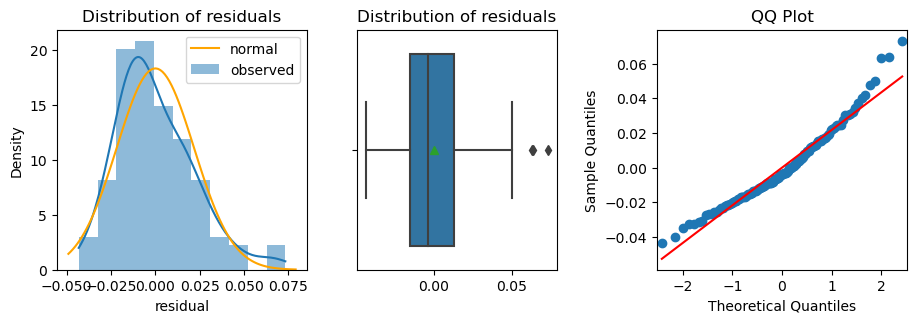

In [28]:
# check residuals from linear regression - are they normally distributed?
fig = plt.figure(figsize=(10,3))
ax1 = fig.add_axes([0.1,0.1,0.25,0.8])
ax2 = fig.add_axes([0.4,0.1,0.2,0.8])
ax3 = fig.add_axes([0.7,0.1,0.25,0.8])

mu, std = stats.norm.fit(model_result.resid)

# plot the residuals
sns.histplot(ax=ax1, x=model_result.resid, stat="density", linewidth=0, kde=True, label = 'observed')
ax1.set(title="Distribution of residuals", xlabel="residual")

# plot corresponding normal curve
xmin, xmax = ax1.get_xlim() # the minimum and maximum x values from the histogram above
x = np.linspace(xmin, xmax, 100) # generate some x values for the normal curve
p = stats.norm.pdf(x, mu, std) # calculate the y values for the normal curve
sns.lineplot(ax=ax1, x=x, y=p, color="orange", label = 'normal')

sns.boxplot(ax=ax2, x=model_result.resid, showmeans=True)
ax2.set(title="Distribution of residuals")

sm.qqplot(model_result.resid, line='s',ax=ax3)
ax3.set(title="QQ Plot")

plt.show()

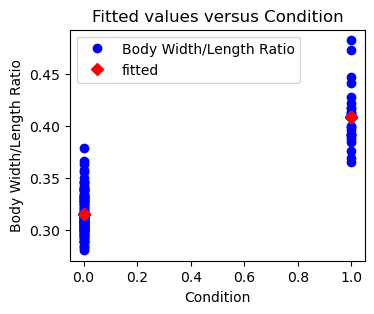

In [29]:
f,a = plt.subplots(1,1,figsize=(3.8,3))
sm.graphics.plot_fit(model_result, 1, vlines=False, ax=a)
plt.show()

# multiple linear regression
### aka ANCOVA (analysis of covariance sez Brooks)

In [30]:
# could do, for example, condition and speed vs. swing duration
# or condition and speed vs. swing duration
ycol = 'Swing duration (lateral legs)'
xcol = 'Speed (body lengths / sec cruising)'
Y = merged_df[ycol]
X = merged_df[['Condition', xcol]] 
X = sm.add_constant(X)
X.head(3)

,const,Condition,Speed (body lengths / sec cruising)
0,1.0,1,0.252280
1,1.0,1,0.174432
2,1.0,1,0.178078


In [31]:
model = sm.OLS(Y, X)
model_res = model.fit()
model_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     Swing duration (lateral legs)   R-squared:                       0.483
Model:                                       OLS   Adj. R-squared:                  0.474
Method:                            Least Squares   F-statistic:                     53.24
Date:                           Thu, 16 May 2024   Prob (F-statistic):           4.70e-17
Time:                                   15:09:33   Log-Likelihood:                 252.73
No. Observations:                            117   AIC:                            -499.5
Df Residuals:                                114   BIC:                            -491.2
Df Model:                                      2                                         
Covariance Type:                       nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   0.3256      0.010     34.075      0.000       0.307       0.344
Condition                               0.0547      0.008      6.740      0.000       0.039       0.071
Speed (body lengths / sec cruising)    -0.2497      0.036     -6.880      0.000      -0.322      -0.178
==============================================================================
Omnibus:                        0.049   Durbin-Watson:                   1.180
Prob(Omnibus):                  0.976   Jarque-Bera (JB):                0.197
Skew:                          -0.012   Prob(JB):                        0.906
Kurtosis:                       2.801   Cond. No.                         14.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

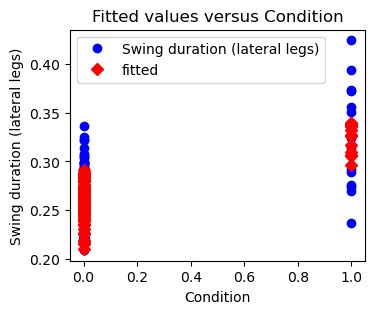

In [32]:
f,a = plt.subplots(1,1,figsize=(3.8,3))
sm.graphics.plot_fit(model_res,1, vlines=False, ax=a)
plt.show()

# Functions for pairwise boxplots and stats

Mann-Whitney U p-val 0.0001


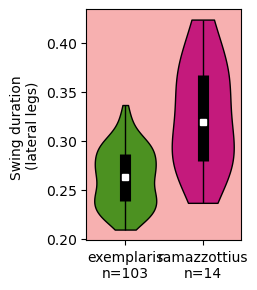

In [33]:
def compViolPlot(ax,df,col,pcolors,vwidth=0.8,scatter=True,medsize=5):
    
    # rearrange groupnames so 'control' is first
    groupnames = sorted(np.unique(df.treatment.values))
    if 'control' in groupnames:
        ind = groupnames.index('control')
        control = groupnames.pop(ind)
        groupnames.insert(0, control)
    
    # collect data
    data_to_plot = []
    for i,group in enumerate(groupnames):
        thisdata = df[df.treatment == group][col].values
        thisdata = thisdata[~np.isnan(thisdata)]
        data_to_plot.append(thisdata)
        
    xpos = [1,2]

    violins = ax.violinplot(data_to_plot, widths=vwidth, showmeans=False, showextrema=False)
    
    for i, pc in enumerate(violins['bodies']):
        pc.set_facecolor(pcolors[i])
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    
        # add scatter over the violin
        if scatter:
            a = 0.7 # alpha
            sz = 4 # size
            sc = 'royalblue' # [ 0.76, 0.86, 0.85 ] # 'k' 'w' # marker color
            ji = 0.02 # jitter around midline
            xScatter = np.random.normal(1, ji, size=len(data_to_plot[i]))
            ax.scatter(xpos[i], data_to_plot[i], s=sz, facecolors=sc, edgecolors=None , alpha = a, zorder = 2)
    
        # homemade box plot
        q1, median, q3 = np.percentile(data_to_plot[i], [25, 50, 75])
        vals = np.sort(data_to_plot[i])

        upper_adjacent_value = q3 + (q3 - q1) * 1.5
        upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

        lower_adjacent_value = q1 - (q3 - q1) * 1.5
        lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)

        whisk_min, whisk_max = lower_adjacent_value, upper_adjacent_value
        ax.vlines(xpos[i], whisk_min, whisk_max, color='k', linestyle='-', lw=1)
        ax.vlines(xpos[i], q1, q3, color='k', linestyle='-', lw=8)
        ax.plot(xpos[i],median,'sw',markersize=medsize)
    
    # add axes labels
    ylab = col
    if '^2' in ylab:
        ylab = ylab.replace('^2','$^2$')
    if '/ sec cruising' in ylab:
        ylab = ylab.replace('/ sec', '/\nsec')
    if '(lateral' in ylab or '(rear' in ylab or '(normalized' in ylab:
        ylab = ylab.replace('(','\n(')
    ax.set_ylabel(ylab)
    ax.set_xticks(np.arange(len(groupnames))+1,groupnames)

    ax.set_xlim([0.5,2.5])
    
    return ax, data_to_plot

def compBoxPlot(ax,df,col): 
 
    # rearrange groupnames so 'control' is first
    groupnames = sorted(np.unique(df.treatment.values))
    if 'control' in groupnames:
        ind = groupnames.index('control')
        control = groupnames.pop(ind)
        groupnames.insert(0, control)
    
    # collect data
    data_to_plot = []
    for i,group in enumerate(groupnames):
        thisdata = df[df.treatment == group][col].values
        thisdata = thisdata[~np.isnan(thisdata)]
        data_to_plot.append(thisdata)
    
    # make boxplot
    bp = ax.boxplot(data_to_plot, patch_artist=True, showfliers=False)
    bp = gaitFunctions.formatBoxPlots(bp, ['black'], ['whitesmoke'], ['dimgrey'])
    
    # add scatter over the boxplot
    a = 1 # alpha
    sc = 'silver' # [ 0.76, 0.86, 0.85 ] # 'k' # color
    sz = 5 # marker size
    ji = 0.02 # jitter around midline
    for i, group in enumerate(groupnames):   
        xScatter = np.random.normal(i+1, ji, size=len(data_to_plot[i]))
        ax.scatter(xScatter, data_to_plot[i], s=sz, facecolors=sc, edgecolors=None , alpha = a, zorder = 2)
    
    # add axes labels
    ylab = col
    if '^2' in ylab:
        ylab = ylab.replace('^2','$^2$')
    if '/ sec cruising' in ylab:
        ylab = ylab.replace('/ sec', '/\nsec')
    if '(lateral' in ylab or '(rear' in ylab or '(normalized' in ylab:
        ylab = ylab.replace('(','\n(')
    ax.set_ylabel(ylab)
    ax.set_xticks(np.arange(len(groupnames))+1,groupnames)
    
    return ax, data_to_plot

def correctMultipleTests(ps,method): # method is 'bonferroni' or 'benjamini-hochberg' or 'benjamini-yekutieli'
    if method == 'bonferroni':
        adj_ps = [x*len(ps) for x in ps]
    elif method == 'benjamini-hochberg' or method == 'bh':
        adj_ps = [x for x in stats.false_discovery_control(ps)]
    elif method == 'benjamini-yekutieli' or method == 'by':
        adj_ps = [x for x in stats.false_discovery_control(ps, method='by')]
    else:
        print('No pvalue adjustment')
        adj_ps = ps
    return adj_ps

def facecolorPval(ax,pval):
    
    if pval < 0.001:
        fc = '#f7b0b0' # pinkish
    elif pval < 0.01:
        fc = '#fcca74' # orange-ish
    elif pval < 0.05:
        fc = '#f6f7a1' # yellow-ish
    else:
        fc = 'white'
    
    ax.set_facecolor(fc)

    return ax

def boxArray(maxcols,df,to_compare):

    if len(to_compare) % maxcols == 0:
        numrows = int(len(to_compare) / maxcols)
        cushion = 0
    else:
        numrows = int(len(to_compare) / maxcols) + 1
        cushion = maxcols - (len(to_compare) % maxcols)
    rows,cols = [numrows,maxcols]
    f,axes = plt.subplots(rows,cols,figsize = (8,2*numrows))
    axes_list = axes.reshape(1,len(to_compare)+cushion)[0]
    pvals = []
    tests = []
    for i, col in enumerate(to_compare):
        axes_list[i], data_to_plot = compBoxPlot(axes_list[i], df, col)
        pval,test = pairwiseStats(data_to_plot)# ,'kw')
        pvals.append(pval)
        tests.append(test)
        axes_list[i].yaxis.label.set_size(tick_fontsize)
        axes_list[i].tick_params(axis='both', which='major', labelsize=tick_fontsize)
    for i in np.arange(cushion):
        axes_list[-(i+1)].set_axis_off()
    print(tests)
    print([np.round(x,3) for x in pvals])

    # adjust p-values for multiple hypothesis testing
    adj_ps = correctMultipleTests(pvals,'by') # 'bonferroni' or 'bh' or 'by'
    print([np.round(x,3) for x in adj_ps])

    # recolor axes based on p-vals
    if cushion != 0:
        axes_list = axes_list[:-cushion]
    for i, ax in enumerate(axes_list):
        ax = facecolorPval(ax,adj_ps[i])

    plt.tight_layout()
    plt.show()

# test comparison plot
f,ax = plt.subplots(1,1,figsize=(2,3))
col = 'Swing duration (lateral legs)'# 
# col = 'Body Length (mm)'
df = getDfForCol(col,[path_summaries_df,step_summaries_df,gait_summaries_df])

# box plot comparison
# ax, data_to_plot = compBoxPlot(ax,df,col)

# violin plot comparison
ax, data_to_plot = compViolPlot(ax,df,col,[con_color,exp_color],scatter=False)

pval, test = pairwiseStats(data_to_plot)
ax = facecolorPval(ax,pval)
control_n = len(df[df['treatment']==control])
exp_n = len(df[df['treatment']==experimental])
ax.set_xticks([1,2],[control+'\nn='+str(control_n),experimental+'\nn='+str(exp_n)]) # comment off if want default ticks
print(test, 'p-val', np.round(pval,4))
plt.show()

T-test p-val 0.0


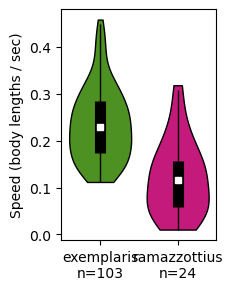

In [34]:
col = 'Speed (body lengths / sec)' # 'Speed (body lengths / sec cruising)' # 
f,ax = plt.subplots(1,1,figsize=(2,3))
df = getDfForCol(col, [path_summaries_df, step_summaries_df, gait_summaries_df])
ax, data_to_plot = compViolPlot(ax,df,col,[con_color,exp_color],scatter=False)
pval, test = pairwiseStats(data_to_plot)
# ax = facecolorPval(ax,pval) # comment off for no p-value color coding
print(test, 'p-val', np.round(pval,7))
control_n = len(df[df['treatment']==control])
exp_n = len(df[df['treatment']==experimental])
ax.set_xticks([1,2],[control+'\nn='+str(control_n),experimental+'\nn='+str(exp_n)]) # comment off if want default ticks
plt.show()

T-test p-val 0.0004588


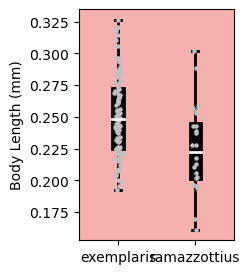

In [35]:
col = 'Body Length (mm)' # 'Body Length (mm)' # 
df = getDfForCol(col, [path_summaries_df, step_summaries_df, gait_summaries_df])
f,ax = plt.subplots(1,1,figsize=(2,3))
ax, data_to_plot = compBoxPlot(ax,df,col)
pval, test = pairwiseStats(data_to_plot)
ax = facecolorPval(ax,pval)
print(test, 'p-val', np.round(pval,7))
plt.show()

# Arrays of boxplots

['T-test', 'Mann-Whitney U', 'Mann-Whitney U', 'T-test', 'Mann-Whitney U', 'T-test']
[0.0, 0.0, 0.0, 0.0, 0.18, 0.0]
[0.001, 0.0, 0.0, 0.0, 0.442, 0.0]


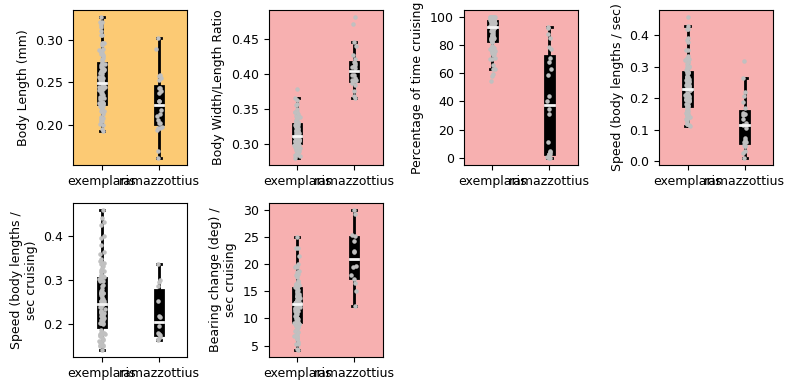

In [36]:
boxArray(4,path_summaries_df,path_cols)

['T-test', 'Mann-Whitney U', 'Mann-Whitney U', 'Mann-Whitney U', 'Mann-Whitney U', 'T-test', 'Mann-Whitney U', 'T-test', 'T-test', 'Mann-Whitney U', 'Mann-Whitney U']
[0.0, 0.0, 0.791, 0.0, 0.004, 0.894, 0.008, 0.761, 0.803, 0.649, 0.096]
[0.0, 0.001, 1.0, 0.0, 0.034, 1.0, 0.055, 1.0, 1.0, 1.0, 0.533]


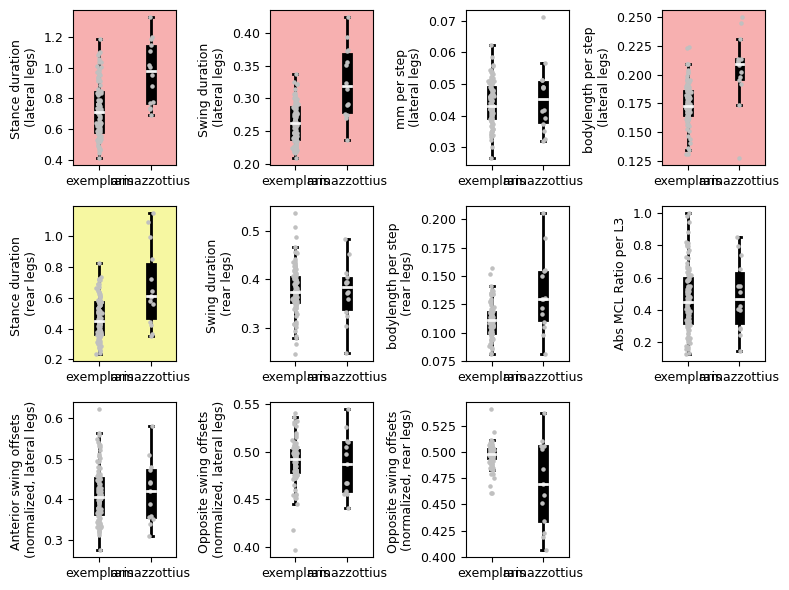

In [37]:
boxArray(4,step_summaries_df,step_cols)

['T-test', 'Mann-Whitney U', 'Mann-Whitney U', 'Mann-Whitney U', 'Mann-Whitney U']
[0.01, 0.467, 0.0, 0.021, 0.585]
[0.059, 1.0, 0.0, 0.079, 1.0]


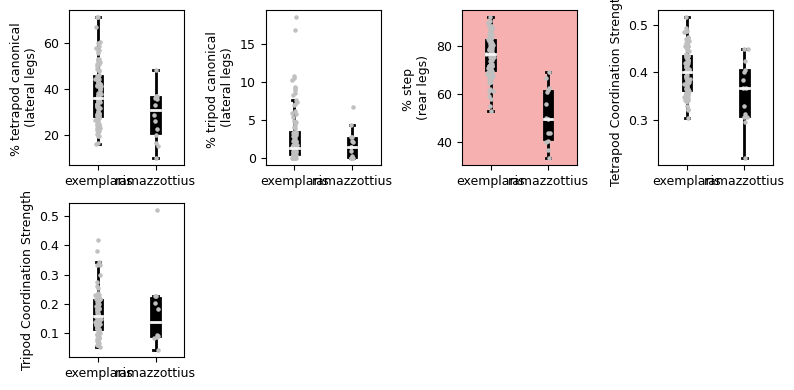

In [38]:
boxArray(4,gait_summaries_df,gait_cols)

# Phenotype Heatmaps and Multiple Comparisons

In [39]:
# which data to compare
# colraw = path_cols + step_cols + gait_cols # get them all from above

# or manually set
colraw  = ['Body Length (mm)', 
           'Speed (body lengths / sec)',
#            'Body Width/Length Ratio', 
           'Percentage of time cruising', 
           'Speed (mm/sec cruising)', 
           'Speed (body lengths / sec cruising)', 
           'Bearing change (deg) / sec cruising', 
           'Stance duration (lateral legs)', 
           'Swing duration (lateral legs)', 
           'mm per step (lateral legs)', 
           'bodylength per step (lateral legs)', 
           'Stance duration (rear legs)', 
           'Swing duration (rear legs)', 
#            'bodylength per step (rear legs)', 
           'Abs MCL Ratio per L3', 
           'Anterior swing offsets (normalized, lateral legs)', 
           'Opposite swing offsets (normalized, lateral legs)', 
           'Opposite swing offsets (normalized, rear legs)', 
           '% tetrapod canonical (lateral legs)',
           'Tetrapod Coordination Strength',
           '% tripod canonical (lateral legs)', 
           'Tripod Coordination Strength',
           '% step (rear legs)', 
           ]


In [40]:
# Clean up category labels for heatmap plot

collablist = [
'Body Length',
'Body Length / sec overall',
# 'Body Width/Length Ratio',
'% sustained walking',
'mm / sec walking',
'Body Length / sec walking',
'Δ˚ / sec walking',
'Stance duration (lat)',
'Swing duration (lat)',
'mm / step (lat)',
'Body Length / step (lat)',
'Stance duration (rear)',
'Swing duration (rear)',
# 'Body Length / step (rear)',
'MCL logratio L3/R3',
'ϕi (lateral)',
'ϕc (lateral)',
'ϕc (rear)',
'% tetrapod canonical',
'Tetrapod CS',
'% tripod canonical',
'Tripod CS',
'% step (rear)'
]

collabs = dict(zip(colraw,collablist))
# be sure we have the right labels
for k in collabs.keys():
    print(k, '-->', collabs[k])

Body Length (mm) --> Body Length
Speed (body lengths / sec) --> Body Length / sec overall
Percentage of time cruising --> % sustained walking
Speed (mm/sec cruising) --> mm / sec walking
Speed (body lengths / sec cruising) --> Body Length / sec walking
Bearing change (deg) / sec cruising --> Δ˚ / sec walking
Stance duration (lateral legs) --> Stance duration (lat)
Swing duration (lateral legs) --> Swing duration (lat)
mm per step (lateral legs) --> mm / step (lat)
bodylength per step (lateral legs) --> Body Length / step (lat)
Stance duration (rear legs) --> Stance duration (rear)
Swing duration (rear legs) --> Swing duration (rear)
Abs MCL Ratio per L3 --> MCL logratio L3/R3
Anterior swing offsets (normalized, lateral legs) --> ϕi (lateral)
Opposite swing offsets (normalized, lateral legs) --> ϕc (lateral)
Opposite swing offsets (normalized, rear legs) --> ϕc (rear)
% tetrapod canonical (lateral legs) --> % tetrapod canonical
Tetrapod Coordination Strength --> Tetrapod CS
% tripod can


label, log2ratio, adjusted pval
Body Length (mm) -0.16215566723820368 0.004390027449083324
Speed (body lengths / sec) -0.965668655596488 5.120217076720809e-08
Percentage of time cruising -1.1588577705535674 2.6366344753936952e-08
Speed (mm/sec cruising) -0.34418097472479786 0.13198665265542
Speed (body lengths / sec cruising) -0.17545500788957508 0.9865600893726693
Bearing change (deg) / sec cruising 0.7481249869657928 2.6366344753936952e-08
Stance duration (lateral legs) 0.4187792440263867 0.00014444401912870565
Swing duration (lateral legs) 0.30536098000524575 0.0008504700947476161
mm per step (lateral legs) 0.051104282106273526 1.0
bodylength per step (lateral legs) 0.23267923589542405 0.00018388780746700261
Stance duration (rear legs) 0.5171398863807833 0.03515126493546744
Swing duration (rear legs) -0.007265107874109254 1.0
Abs MCL Ratio per L3 0.05313495540426157 1.0
Anterior swing offsets (normalized, lateral legs) 0.01748642633261994 1.0
Opposite swing offsets (normalized, lat

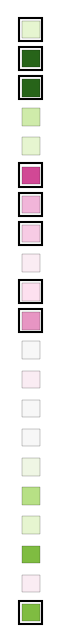

In [41]:
# function for Z-scores, log ratio plots, and combining dataframes
def pairZscore(data,conditions): # I do not use this function anywhere
    # data is a vector of numbers for control and experimental treatments
    # conditions is a vector of 0 and 1 (for pairs), where
    # 'control' is assumed to be 0
    control_data = data[np.where(conditions==0)]
    exp_data = data[np.where(conditions==1)]
    control_mean = np.nanmean(control_data)
    control_std = np.nanstd(control_data)
    exp_std = np.nanstd(exp_data)
    zscores = np.zeros(len(data))
    for i, d in enumerate(data):
        if conditions[i] == 0: # control!
            zscores[i] = (d-control_mean)/control_std
        elif conditions[i] == 1:
            zscores[i] = (d-control_mean)/exp_std
    return zscores

def ratioPlot(ax, dflist, colslist, collabs, control='control', cmap='bwr', plotLabels = True):
    '''
    Parameters
    
    dflist: a list of dataframes, usually path_summaries_df, step_summaries_df, gait_summaries_df
         or pdf, sdf, gdf
    colslist: a list columns within these dataframes
    '''

    # find total number of comparisons
    total_cols = len(colslist)
    
    # make empty containers for log ratios and pvals and labels
    log2ratios = np.zeros(total_cols)
    pvals = np.zeros(total_cols)
    labels = np.empty(total_cols, dtype='object')
    idx = 0 # index for these containers
    
    # go through list of columns to analyze
    for i, column in enumerate(colslist):
        
        df = getDfForCol(column, dflist)

        # set control to 0 and experimental to 1
        df['Condition'] = np.where(df['treatment'] == control, 0, 1)
        conditions = df['Condition'].values

        # get the data for that column
        data = df[column].values
        control_data = data[np.where(conditions==0)]
        exp_data = data[np.where(conditions==1)]

        # remove nan (no data)
        control_data = control_data[~np.isnan(control_data)]
        exp_data = exp_data[~np.isnan(exp_data)]

        # get pval for this column            
        pval, test = pairwiseStats([control_data, exp_data])
#       print(column, pval, test) # testing
        pvals[i] = pval

        # get label for this column
        labels[i] = column

        # get log2(experiment/control) ratio for this column (CLR causes trouble!)
        log2ratios[i] = np.log2(np.mean(exp_data)/np.mean(control_data))          

    # correct pvals for multiple comparisons
    adj_pvals = correctMultipleTests(pvals,'by')
    
    ytext = 0.25 # level for text above the lower edge of each square

    ylevel = len(labels) + 1
    
    big_box = 0.4
    small_box = 0.3

    # go through data
    for i, label in enumerate(labels):
    
        # plot a square, with color scaled to log2_ratio
        square_color = getLevelColor(cmap, log2ratios[i])
        
        square_center_x = 0.53
        square_center_y = ylevel + 0.505
        
        # plot a box around square if significant
        if adj_pvals[i] < 0.05:
            linewidth = 0.1 # 0.1 or 3 or 5
            ec = 'k'
#             ax.text(0.25,ylevel,s='*',fontsize=axis_fontsize) # or comment out
            square = patches.Rectangle((square_center_x-big_box, square_center_y-big_box), 
                                       2*big_box, 2*big_box, linewidth=1, edgecolor='k', facecolor='w')        
            ax.add_patch(square)
        else:
            linewidth = 0.1
            ec = 'k'
        
        square = patches.Rectangle((square_center_x-small_box+0.025, square_center_y-small_box-0.01), 
                                   2*small_box, 2*small_box, linewidth=linewidth, 
                                   edgecolor=ec, facecolor=square_color)        
        ax.add_patch(square)
        
        # plot the text
        if plotLabels:
#             label = label.replace('normalized, ','')
#             label = label.replace(' legs','')
            ax.text(1.1,ylevel+ytext,s=collabs[label],fontsize=tick_fontsize, horizontalalignment='left')

        # plot horizontal lines to separate the different dataframes ?
        
        # update ylevel
        ylevel = ylevel-1

    ax.set_ylim([2,len(labels) + 2])
    ax.set_aspect('equal')
#     ax.set_xlim([0,1])
    ax.set_axis_off()
    return ax, log2ratios, pvals, adj_pvals, labels

dfs = [path_summaries_df, step_summaries_df, gait_summaries_df]
f,ax = plt.subplots(figsize=(2,5.3), dpi=150, facecolor=(1,1,1,0))
print()
ax, log2_ratios, pvals, adj_pvals, labels = ratioPlot(ax, dfs, colraw, collabs,
                                                      control, cmap, False) # False to hide labels on heatmap

# add label for comparison
comparison= control + ' vs. ' + experimental
# ax.text(0.1,1.7,s=comparison,rotation=270,fontsize=tick_fontsize, verticalalignment='top')

adj_pval_dict = dict(zip(labels,adj_pvals))
print('label, log2ratio, adjusted pval')
for i, lab in enumerate(labels):
    print(lab, log2_ratios[i], adj_pval_dict[lab])
plt.show()

# graphs for a particular comparison of interest

exemplaris n = 103
ramazzottius n = 14
T-test p-val 9.4e-06
Adjusted p-val 0.0001444


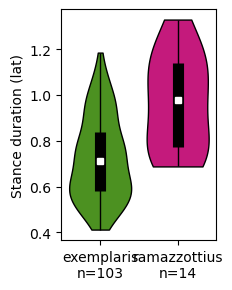

In [42]:
# violin plots
diffcols = ['Body Length (mm)', # 0
            'Body Width/Length Ratio', # 1
           'bodylength per step (lateral legs)', # 2
           'Bearing change (deg) / sec cruising', # 3
           'Stops / sec', # 4
           'Stance duration (lateral legs)', # 5
            'Swing duration (lateral legs)', # 6
            'bodylength per step (lateral legs)', # 7
            'Stance duration (rear legs)', # 8
            '% step (rear legs)' # 9
           ]

col =  diffcols[5] # <----- change this index for different columns
df = getDfForCol(col, [path_summaries_df, step_summaries_df, gait_summaries_df])

f,ax = plt.subplots(1,1,figsize=(2,3))
controln = len(df[df['Condition']==0][col].values)
expn = len(df[df['Condition']==1][col].values)

control_lab = control + '\nn=' + str(controln)
exp_lab = experimental + '\nn=' + str(expn)

print(control,'n =', controln)
print(experimental,'n =',expn)

ax, data_to_plot = compViolPlot(ax,df,col,[con_color,exp_color],scatter=False)
ax.set_ylabel(collabs[col])
pval, test = pairwiseStats(data_to_plot)
apval = adj_pval_dict[col]
# ax = facecolorPval(ax,pval) # comment off for no p-value color coding
print(test, 'p-val', np.round(pval,7))
print('Adjusted p-val', np.round(apval,7))
ax.set_xticks([1,2],[control_lab, exp_lab]) # comment off if want default ticks
plt.show()

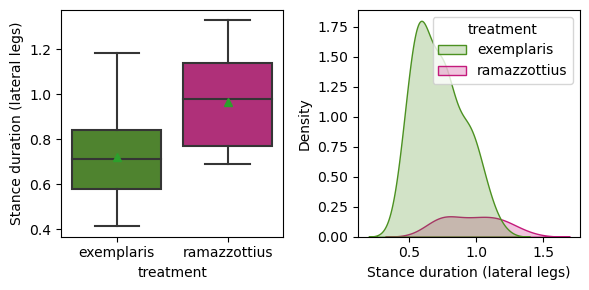

In [43]:
# sns-style plots
f,(a1,a2) = plt.subplots(1,2,figsize=(6,3))
sns.boxplot(ax=a1, x=df['treatment'], palette=palette, y=df[col], showmeans=True)
sns.kdeplot(ax=a2, x=col, hue='treatment', palette=palette, data=df, fill=True)
plt.tight_layout()
plt.show()

# Pairwise gait style comparisons

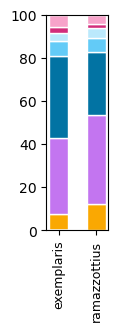

In [44]:
def gaitStylePercentagesPlot(ax, df, control='control', leg_set='lateral', addLegend=True):
    
    barWidth = 0.5
    df = df.copy()
    ylab = 'Percentage in Gait Style'

    # set up colors
    if leg_set in ['rear','two','human']:
        all_combos, combo_colors = gaitFunctions.get_gait_combo_colors('rear')
        columns = ['% stand (rear legs)', '% step (rear legs)','% hop (rear legs)']
        ylab += '\n(Rear Legs)'
    elif leg_set in ['four','cat','dog','tetrapod']:
        all_combos, combo_colors = gaitFunctions.get_gait_combo_colors('four')
    elif leg_set in ['lateral','insect','six']:
        all_combos, combo_colors = gaitFunctions.get_gait_combo_colors('lateral')
        columns = [x for x in gdf.columns if '%' in x]
        columns = [x for x in columns if 'lateral' in x]
        columns = [x for x in columns if 'total' not in x]
        ylab += '\n(Lateral Legs)'
#     print(combo_colors) # test OK
#     print(columns) # test OK
    
    # set control to 0 and experimental to 1
    df['Condition'] = np.where(df['treatment'] == control, 0, 1)
    conditions = df['Condition'].values
    exp_name = np.unique(df.treatment.values[np.where(conditions==1)])[0]
#     print(exp_name)
  
    bottoms = [0,0]
    for c, column in enumerate(columns):
        data = df[column].values
        control_mean = np.mean(data[np.where(conditions==0)])
        exp_mean = np.mean(data[np.where(conditions==1)])
        for i, val in enumerate([control_mean, exp_mean]):
            if i == 0: # plot for legend
                ax.bar(i, 0, bottom = 0, color = combo_colors[all_combos[c]],
                       edgecolor='white', width=barWidth, label=all_combos[c].replace('_',' '))
            ax.bar(i, val, bottom=bottoms[i], color=combo_colors[all_combos[c]],
                  edgecolor='white',width=barWidth)
            bottoms[i] += val
    
    ax.set_xticks(np.arange(2))
    ax.set_xticklabels([control, exp_name], fontsize=tick_fontsize, rotation=90)
    
    # Add a legend
    if addLegend:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(reversed(handles), reversed(labels), loc='upper left',
                  bbox_to_anchor=(1,1), ncol=1, fontsize=tick_fontsize)
        ax.set_ylabel(ylab, fontsize=axis_fontsize)
    ax.set_ylim([0,100]) 

    return ax

df = gait_summaries_df.copy()
f, ax = plt.subplots(1,1,figsize=(0.8,2.8))
ax = gaitStylePercentagesPlot(ax, df, control, 'lateral', False) # False to hide legend and Y label
plt.show()

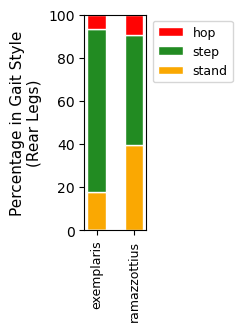

In [45]:
df = gait_summaries_df.copy()
f, ax = plt.subplots(1,1,figsize=(0.8,2.8))
ax = gaitStylePercentagesPlot(ax, df, control, 'rear', True) # False to hide legend and Y label
plt.show()

# ternary plots and compositional statistics

In [46]:
from gaitFunctions import colorBoxplot
from gaitFunctions import pairwiseStats
import mpltern
import composition_stats as cs
gait_summaries_df.head(5)

,Identifier,treatment,individual,date,Number of frames,% stand (lateral legs),% pentapod (lateral legs),% tetrapod canonical (lateral legs),% tetrapod gallop (lateral legs),% tetrapod other (lateral legs),...,CLR tetrapod canonical (lateral legs),CLR tetrapod gallop (lateral legs),CLR tetrapod other (lateral legs),CLR tripod canonical (lateral legs),CLR tripod other (lateral legs),CLR other (lateral legs),CLR stand (rear legs),CLR step (rear legs),CLR hop (rear legs),Condition
0,hp_14sep_tardigrade01_ramazzottius,ramazzottius,tardigrade01,14sep,357,2.240896,24.089636,36.694678,8.123249,11.764706,...,0.154793,1.745756,1.685388,1.965275,2.297787,1.960805,-0.074672,-0.153803,1.217059,1
1,hp_14sep_tardigrade02_ramazzottius,ramazzottius,tardigrade02,14sep,428,11.915888,48.130841,26.401869,2.803738,7.009346,...,-0.174404,0.681980,1.167529,0.397593,0.892624,-0.956284,0.175443,-0.061593,-0.023720,1
2,jc_14sep_tardigrade03_ramazzottius,ramazzottius,tardigrade03,14sep,559,6.440072,41.681574,48.121646,0.894454,0.178891,...,0.425893,-0.460515,-2.500695,0.823714,-0.578375,-0.956284,-0.467127,0.390776,-0.290746,1
3,rm_14sep_tardigrade01_ramazzottius,ramazzottius,tardigrade01,14sep,285,13.333333,56.140351,28.771930,0.000000,1.754386,...,-0.088439,-3.527028,-0.217597,-3.118267,-3.134062,-0.956284,0.380887,-0.237440,-1.265744,1
4,sp_14sep_tardigrade04_ramazzottius,ramazzottius,tardigrade04,14sep,682,15.249267,50.439883,22.873900,6.744868,1.906158,...,-0.317843,1.559808,-0.134626,-0.068314,0.522027,0.908046,-0.014532,0.062059,0.363151,1


In [47]:
exp = gait_summaries_df[gait_summaries_df['treatment']==experimental]
con = gait_summaries_df[gait_summaries_df['treatment']==control]
print(np.shape(exp), np.shape(con))

(14, 34) (103, 34)


In [48]:
stand_rear_exp = exp['% stand (rear legs)'].values
stand_rear_con = con['% stand (rear legs)'].values
step_rear_exp = exp['% step (rear legs)'].values
step_rear_con = con['% step (rear legs)'].values
hop_rear_exp = exp['% hop (rear legs)'].values
hop_rear_con = con['% hop (rear legs)'].values

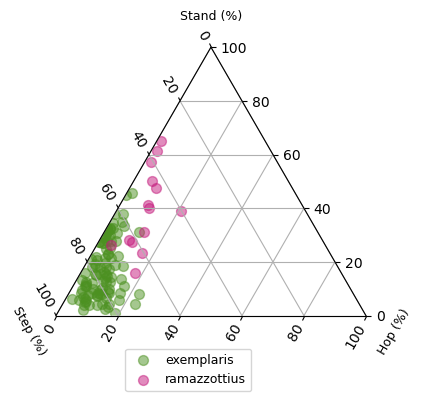

In [49]:
fig = plt.figure(figsize=(4,4),dpi=100,facecolor=(1,1,1,0))
ax = fig.add_subplot(projection="ternary", ternary_sum=100.0)

ax.scatter(stand_rear_con, step_rear_con, hop_rear_con,
           color=con_color,s=50,alpha=0.5,label=control)
ax.scatter(stand_rear_exp, step_rear_exp, hop_rear_exp,
           color=exp_color,s=50,alpha=0.5,label=experimental)

ax.set_tlabel("Stand (%)", fontsize=tick_fontsize)
ax.set_llabel("Step (%)", fontsize=tick_fontsize)
ax.set_rlabel("Hop (%)", fontsize=tick_fontsize)

ax.grid()
# ax.legend(fontsize=tick_fontsize, bbox_to_anchor=(0.55, -0.9, 0.5, 0.5) )# , loc='lower center') # 1.3 size
ax.legend(fontsize=tick_fontsize, bbox_to_anchor=(0.15, -0.6, 0.5, 0.5) )# , loc='lower center') # 4 size

plt.show()

In [50]:
stand_lateral_exp = exp['% stand (lateral legs)'].values
stand_lateral_con = con['% stand (lateral legs)'].values

pentapod_exp = exp['% pentapod (lateral legs)'].values
pentapod_con = con['% pentapod (lateral legs)'].values

tetrapod_canonical_exp = exp['% tetrapod canonical (lateral legs)'].values
tetrapod_canonical_con = con['% tetrapod canonical (lateral legs)'].values

tetrapod_gallop_exp = exp['% tetrapod gallop (lateral legs)'].values
tetrapod_gallop_con = con['% tetrapod gallop (lateral legs)'].values

tetrapod_other_exp = exp['% tetrapod other (lateral legs)'].values
tetrapod_other_con = con['% tetrapod other (lateral legs)'].values

tetrapod_total_exp = exp['% tetrapod total (lateral legs)'].values
tetrapod_total_con = con['% tetrapod total (lateral legs)'].values

tripod_canonical_exp = exp['% tripod canonical (lateral legs)'].values
tripod_canonical_con = con['% tripod canonical (lateral legs)'].values

tripod_other_exp = exp['% tripod other (lateral legs)'].values
tripod_other_con = con['% tripod other (lateral legs)'].values

tripod_total_exp = exp['% tripod total (lateral legs'].values
tripod_total_con = con['% tripod total (lateral legs'].values

# 'total' here is pentapod + tetrapod + tripod
total_exp =  pentapod_exp + tetrapod_total_exp + tripod_total_exp
total_con =  pentapod_con + tetrapod_total_con + tripod_total_con

pentapod_percent_exp = pentapod_exp / total_exp
tetrapod_percent_exp = tetrapod_total_exp / total_exp
tripod_percent_exp = tripod_total_exp / total_exp
# print(pentapod_percent_exp + tetrapod_percent_exp + tripod_percent_exp)# testing OK

pentapod_percent_con = pentapod_con / total_con
tetrapod_percent_con = tetrapod_total_con / total_con
tripod_percent_con = tripod_total_con / total_con
# print(pentapod_percent_con + tetrapod_percent_con + tripod_percent_con)# testing OK


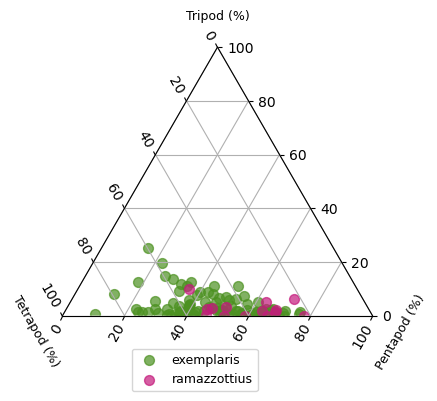

In [51]:
fig = plt.figure(figsize=(4,4),dpi=100,facecolor=(1,1,1,0))
ax = fig.add_subplot(projection="ternary", ternary_sum=100.0)

# total
# ax.scatter(pentapod_percent_con, tetrapod_percent_con, tripod_percent_con,c=con_color,s=10,label=control)
# ax.scatter(pentapod_percent_exp, tetrapod_percent_exp, tripod_percent_exp,c=exp_color,s=10,label=experimental)
# ax.set_tlabel("Pentapod (%)")
# ax.set_llabel("Tetrapod (%)")
# ax.set_rlabel("Tripod (%)")

# canonical
ax.scatter(tripod_canonical_con, tetrapod_canonical_con, pentapod_con, 
           color=con_color,s=50,alpha=0.7,label=control)
ax.scatter(tripod_canonical_exp, tetrapod_canonical_exp, pentapod_exp, 
           color=exp_color,s=50,alpha=0.7,label=experimental)
ax.set_tlabel("Tripod (%)", fontsize=tick_fontsize)
ax.set_llabel("Tetrapod (%)", fontsize=tick_fontsize)
ax.set_rlabel("Pentapod (%)", fontsize=tick_fontsize)

ax.grid()
# ax.legend(fontsize=tick_fontsize, bbox_to_anchor=(0.35, -0.7, 0.5, 0.5) )#, loc='lower center') # 1.3 size
ax.legend(fontsize=tick_fontsize, bbox_to_anchor=(0.15, -0.6, 0.5, 0.5) )# , loc='lower center') # 4 size

plt.show()

# compositional data = log ratio transform

In [52]:
# rear legs
rear_labs = ['stand','step','hop']
treatments = gait_summaries_df.treatment.values
control_ix = np.where(treatments == control)[0]
exp_ix = np.where(treatments == experimental)[0]
rear_percentages = np.hstack([[
    gait_summaries_df['% stand (rear legs)'].values,
    gait_summaries_df['% step (rear legs)'].values,
    gait_summaries_df['% hop (rear legs)'].values
                             ]])
print(np.sum(rear_percentages,0)) # should all be 100 ... check!
rear_percentages_nozeros = cs.multiplicative_replacement(rear_percentages)
print(np.sum(rear_percentages_nozeros,0)) # should still be 100-ish ... check!
rear_clr = cs.clr(rear_percentages_nozeros)

[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100.]
[ 99.99386123  99.99822492  99.99864091  99.99948736  99.99738643
  99.99702933  99.99959132  99.99940366  99.99725103  99.99755037
  99.99486901  99.99629873  99.99531221  99.99679437  99.99945687
  99.99829029  99.99971126  99.99678574  99.99959075  99.99722199
  99.99847864  99.99333071 100.00007305  99.9997115  100.00007305
  99.99725504 100.00007305  99.99990128  99.99774782  99.99809213
  99.9996

In [53]:
print(gait_summaries_df.columns)

Index(['Identifier', 'treatment', 'individual', 'date', 'Number of frames',
       '% stand (lateral legs)', '% pentapod (lateral legs)',
       '% tetrapod canonical (lateral legs)',
       '% tetrapod gallop (lateral legs)', '% tetrapod other (lateral legs)',
       '% tetrapod total (lateral legs)', '% tripod canonical (lateral legs)',
       '% tripod other (lateral legs)', '% tripod total (lateral legs',
       '% other (lateral legs)', '% stand (rear legs)', '% hop (rear legs)',
       '% step (rear legs)', 'Tetrapod Coordination Strength',
       'Tetrapod Bout Speed (bodylength / s)', 'Tripod Coordination Strength',
       'Tripod Bout Speed (bodylength / s)', 'CLR stand (lateral legs)',
       'CLR pentapod (lateral legs)', 'CLR tetrapod canonical (lateral legs)',
       'CLR tetrapod gallop (lateral legs)',
       'CLR tetrapod other (lateral legs)',
       'CLR tripod canonical (lateral legs)',
       'CLR tripod other (lateral legs)', 'CLR other (lateral legs)',
       'CLR

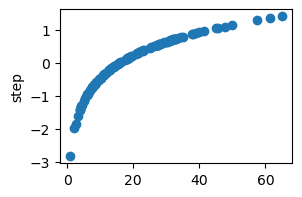

In [54]:
# rear_clr should still be proportional to rear_percentages, no?
col = 1 # 0=stand, 1=step, 2=hop
f,a = plt.subplots(1,1,figsize=(3,2),facecolor=(1,1,1,0))
a.scatter(rear_percentages[0],rear_clr[0])
a.set_ylabel(rear_labs[col])
plt.show()
# yes, in a loggish way

p =  0.0 by Mann-Whitney U


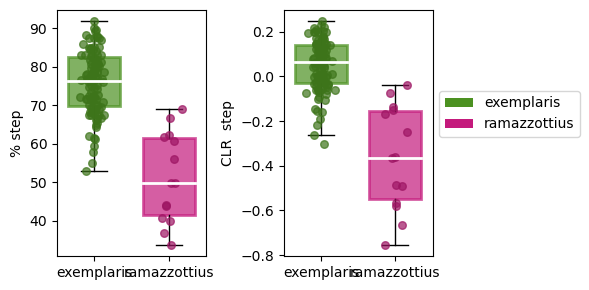

In [55]:
# REAR boxplot
col = 1 # 0=stand, 1=step, 2=hop
from matplotlib.patches import Patch
f,[a1,a2] = plt.subplots(1,2,figsize=(6,3))
labels = [control,experimental]
rear_boxdata = [rear_percentages[col][control_ix], rear_percentages[col][exp_ix]]
a1,bp1=colorBoxplot(a1,rear_boxdata,[con_color,exp_color],labels, 30,0.8)
a1.set_ylabel('% ' + rear_labs[col])

rear_clr_boxdata = [rear_clr[col][control_ix], rear_clr[col][exp_ix]]
a2,bp2=colorBoxplot(a2,rear_clr_boxdata,[con_color,exp_color],labels, 30,0.8)
a2.set_ylabel('CLR  '+ rear_labs[col])

legend_elements = [Patch(facecolor=con_color, edgecolor=None,
                         label=control),
                  Patch(facecolor=exp_color, edgecolor=None,
                         label=experimental)]
a2.legend(handles=legend_elements, bbox_to_anchor=(1, 0.2, 0.5, 0.5))

plt.tight_layout()

pval, test = pairwiseStats(rear_clr_boxdata)
print('p = ', np.round(pval,6), 'by', test)
plt.show()



p =  0.0 by Mann-Whitney U


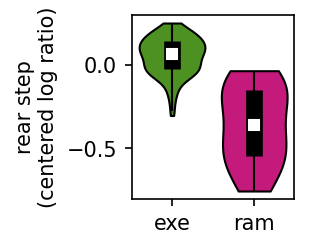

In [56]:
# just CLR from above
f,a = plt.subplots(1,1,figsize=(1.4,1.6), facecolor=(1,1,1,0),dpi=150)

# boxplot
# a,bp=colorBoxplot(a,rear_clr_boxdata,[con_color,exp_color],labels,10,0.8)

# violinplot
a = gaitFunctions.colorViolinPlot(a,rear_clr_boxdata,[con_color,exp_color],labels,inner='box')

a.set_ylabel('rear ' + rear_labs[col] + '\n(centered log ratio)')
pval, test = pairwiseStats(rear_clr_boxdata)
print('p = ', np.round(pval,6), 'by', test)

# legend (outside of plot)
# legend_elements = [Patch(facecolor=con_color, edgecolor=None,
#                          label=control),
#                   Patch(facecolor=exp_color, edgecolor=None,
#                          label=experimental)]
# a.legend(handles=legend_elements, bbox_to_anchor=(1, 0.2, 0.5, 0.5))

a.set_xticks([1,2],[control[:3], experimental[:3]])

plt.show()



In [57]:
# LATERAL legs
lateral_percentages = np.hstack([[
    gait_summaries_df['% stand (lateral legs)'].values,
    gait_summaries_df['% pentapod (lateral legs)'].values,
    gait_summaries_df['% tetrapod canonical (lateral legs)'].values,
    gait_summaries_df['% tetrapod gallop (lateral legs)'].values,
    gait_summaries_df['% tetrapod other (lateral legs)'].values,
    gait_summaries_df['% tripod canonical (lateral legs)'].values,
    gait_summaries_df['% tripod other (lateral legs)'].values,
    gait_summaries_df['% other (lateral legs)'].values
                             ]])
lat_labs = ['stand','pentapod','tetrapod canonical','tetrapod gallop','tetrapod other',
       'tripod canonical','tripod other',' other']

print(np.sum(lateral_percentages,0)) # should all be 100 ... check!
lateral_percentages_nozeros = cs.multiplicative_replacement(lateral_percentages)
print(np.sum(lateral_percentages_nozeros,0)) # should still be 100-ish ... check!
lateral_clr = cs.clr(lateral_percentages_nozeros)



[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100.]
[99.98260682 99.99522572 99.99606111 99.99834417 99.99245921 99.99033737
 99.99080115 99.99126051 99.98688817 99.99436455 99.99028156 99.99646107
 99.9924554  99.99694047 99.9951357  99.99092868 99.99519334 99.9825042
 99.99317717 99.98641862 99.99047841 99.9584017  99.99513854 99.99157272
 99.99685677 99.99848584 99.99550914 99.99614802 99.99891982 99.9960964
 99.99364492 99.99245136 99.99022242 99.99

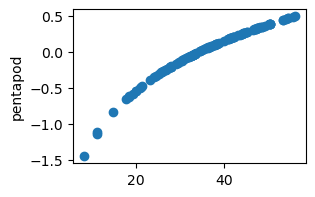

In [58]:
# lateral clr should still be proportional to lateral percentages, no?
col = 1 # 0=stand 1=pentapod 2=tetrapod canonical 3=tetrapod gallop 4=tetrapod other
#         5=tripod canonical 6=tripod other 7=other
f,a = plt.subplots(1,1,figsize=(3,2))
a.scatter(lateral_percentages[col],lateral_clr[col])
a.set_ylabel(lat_labs[col])
plt.show()
# yes, in a loggish way

p =  0.002914 by T-test


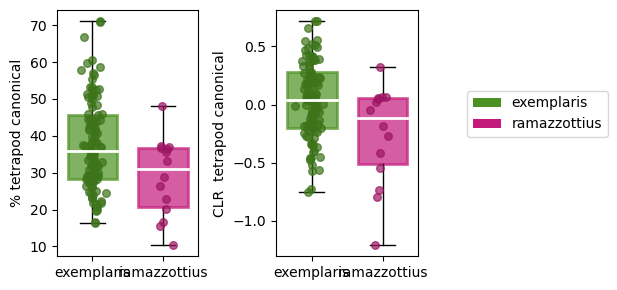

In [59]:
# LATERAL boxplot a:  % for ex vs. ram, 2: clr for ex vs. ram
from matplotlib.patches import Patch
col = 2 # 0=stand 1=pentapod 2=tetrapod canonical 3=tetrapod gallop 4=tetrapod other
#         5=tripod canonical 6=tripod other 7=other
f,[a1,a2] = plt.subplots(1,2,figsize=(6,3))
lateral_boxdata = [lateral_percentages[col][control_ix], lateral_percentages[col][exp_ix]]
a1,bp1=colorBoxplot(a1,lateral_boxdata,[con_color,exp_color],[control,experimental],30,0.8)
a1.set_ylabel('% ' + lat_labs[col])

lateral_clr_boxdata = [lateral_clr[col][control_ix], lateral_clr[col][exp_ix]]
a2,bp2=colorBoxplot(a2,lateral_clr_boxdata,[con_color,exp_color],[control,experimental],30,0.8)
a2.set_ylabel('CLR  '+ lat_labs[col])

pval, test = pairwiseStats(lateral_clr_boxdata)
print('p = ', np.round(pval,6), 'by', test)

legend_elements = [Patch(facecolor=con_color, edgecolor=None,
                         label=control),
                  Patch(facecolor=exp_color, edgecolor=None,
                         label=experimental)]
# a2.set_ylim([-3,2])
a2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 0.2, 0.5, 0.5))
plt.tight_layout()
plt.show()



TypeError: list indices must be integers or slices, not str

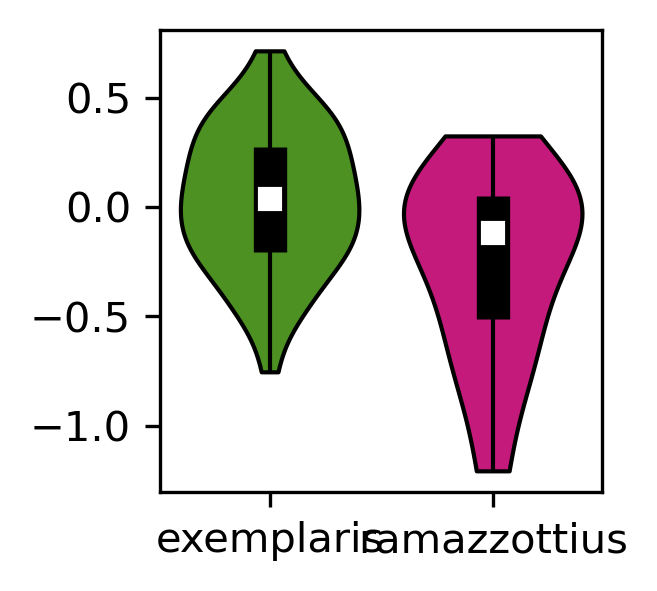

In [84]:
# just CLR from above
f,a = plt.subplots(1,1,figsize=(1.9,2), facecolor=(1,1,1,0),dpi=300)

# boxplot
# a,bp=colorBoxplot(a,rear_clr_boxdata,[con_color,exp_color],labels,10,0.8)

# violinplot
a = gaitFunctions.colorViolinPlot(a,lateral_clr_boxdata,[con_color,exp_color],labels,inner='box')

a.set_ylabel(lat_labs[col] + '\n(centered log ratio)')
pval, test = pairwiseStats(lateral_clr_boxdata)
print('p = ', np.round(pval,6), 'by', test)

# legend (outside of plot)
# legend_elements = [Patch(facecolor=con_color, edgecolor=None,
#                          label=control),
#                   Patch(facecolor=exp_color, edgecolor=None,
#                          label=experimental)]
# a.legend(handles=legend_elements, bbox_to_anchor=(1, 0.2, 0.5, 0.5))

a.set_xticks([1,2],[control, experimental[:3]])
# a.set_ylim([-5,4])

plt.show()

# collected plots for figure

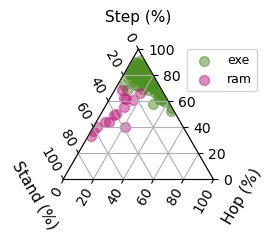

In [61]:
# ternary plot at correct size
fig = plt.figure(figsize=(1.94,1.94),dpi=100,facecolor=(1,1,1,0))
ax = fig.add_subplot(projection="ternary", ternary_sum=100.0)

ax.scatter(step_rear_con, hop_rear_con, stand_rear_con,
           color=con_color,s=50,alpha=0.5,label=control[:3])
ax.scatter(step_rear_exp, stand_rear_exp, hop_rear_exp,
           color=exp_color,s=50,alpha=0.5,label=experimental[:3])

ax.set_tlabel("Step (%)", fontsize=axis_fontsize)
ax.set_llabel("Stand (%)", fontsize=axis_fontsize)
ax.set_rlabel("Hop (%)", fontsize=axis_fontsize)

ax.grid()
ax.legend(fontsize=tick_fontsize, bbox_to_anchor=(0.83, 0.55, 0.5, 0.5)) # 1.9 size

plt.show()

p =  0.0 by Mann-Whitney U


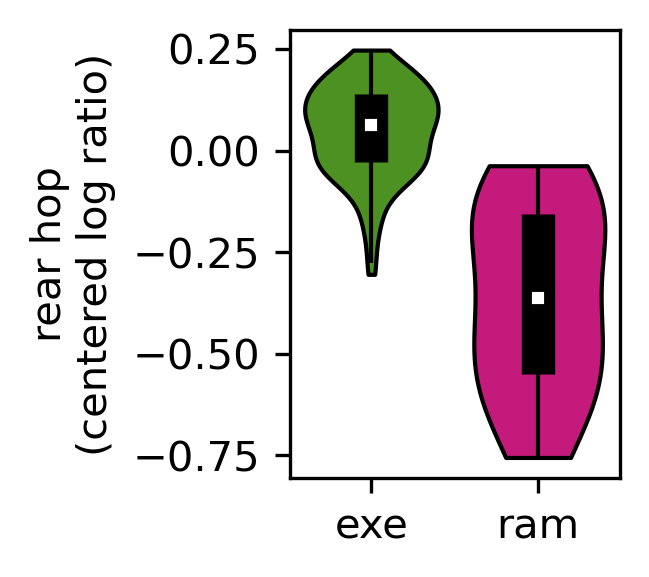

In [62]:
# rear CLR plot at correct size
f,a = plt.subplots(1,1,figsize=(1.42,1.94), facecolor=(1,1,1,0), dpi=300)
medsize=2
vwidth=0.8
# violinplot
a = gaitFunctions.colorViolinPlot(a,rear_clr_boxdata,[con_color,exp_color],labels,inner='box',
                                  medsize=medsize, vwidth=0.8)

a.set_ylabel('rear ' + rear_labs[col] + '\n(centered log ratio)')
pval, test = pairwiseStats(rear_clr_boxdata)
print('p = ', np.round(pval,6), 'by', test)
a.set_xticks([1,2],[control[:3], experimental[:3]])

plt.show()

In [63]:
diffcols = ['Body Length (mm)', # 0
            'Body Width/Length Ratio', # 1
           'bodylength per step (lateral legs)', # 2
           'Bearing change (deg) / sec cruising', # 3
           'Stops / sec', # 4
           'Stance duration (lateral legs)', # 5
            'Swing duration (lateral legs)', # 6
            'bodylength per step (lateral legs)', # 7
            'Stance duration (rear legs)', # 8
            '% step (rear legs)' # 9
           ]

In [64]:
print(collabs[diffcols[0]])

Body Length


Bearing change (deg) / sec cruising -> p =  2.6366344753936952e-08
bodylength per step (lateral legs) -> p =  0.00018388780746700261
Stance duration (lateral legs) -> p =  0.00014444401912870565


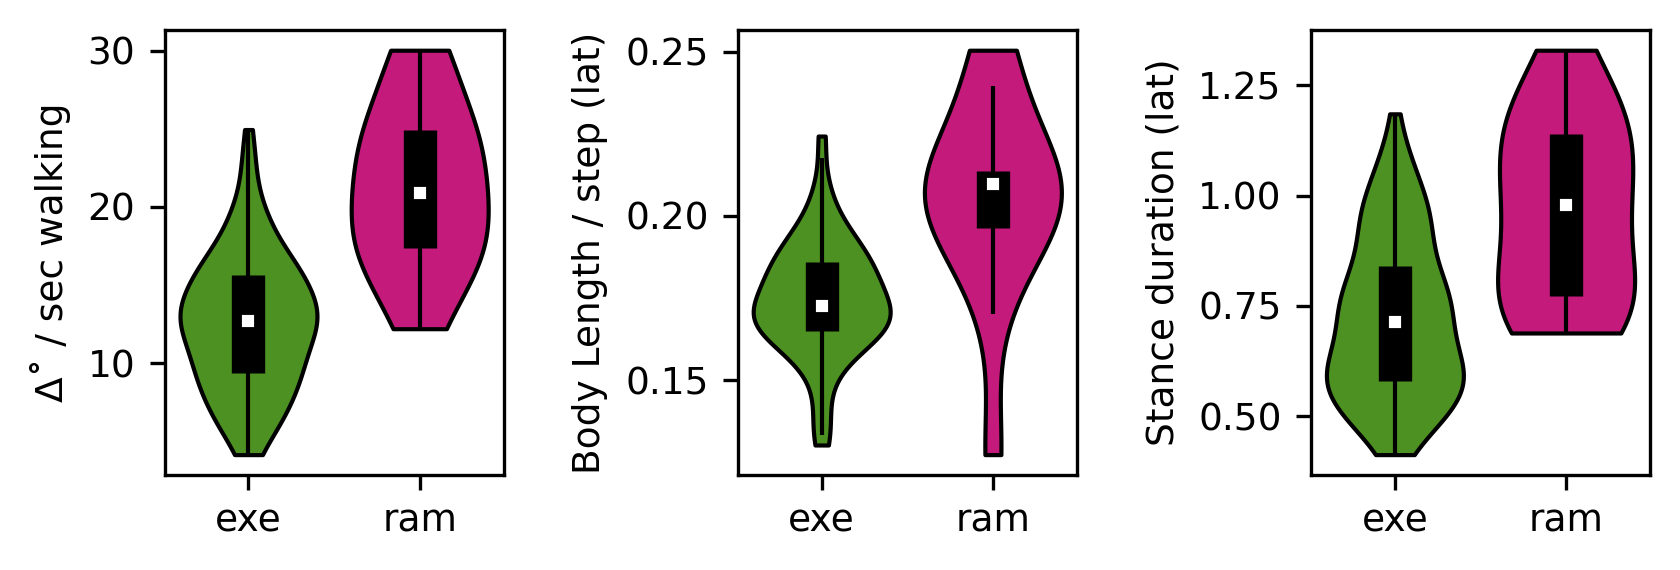

In [65]:
# violin plots
f,axes=plt.subplots(1,3,figsize=(5.7,2),dpi=300)
[a1,a2,a3] = axes

axcols = [diffcols[3], diffcols[2], diffcols[5]]
axlabs = [collabs[x] for x in axcols]

con_lab = control
exp_lab = experimental
medsize = 2
vwidth = 0.8

for i, ax in enumerate([a1,a2,a3]):
    axcol = axcols[i]
    axdf = getDfForCol(axcol,[path_summaries_df,step_summaries_df,gait_summaries_df])
    condata = axdf[axdf['Condition']==0][axcol].values
    expdata = axdf[axdf['Condition']==1][axcol].values
    condata = gaitFunctions.omitNan(condata)
    expdata = gaitFunctions.omitNan(expdata)
    ax = gaitFunctions.colorViolinPlot(ax,[condata,expdata],[con_color,exp_color],
                                  [con_lab,exp_lab],inner='box',medsize=medsize,vwidth=vwidth,pointcolor=None)
    ax.set_ylabel(axlabs[i])
    ax.set_xticks([1,2],[control[:3], experimental[:3]])
    ax.yaxis.label.set_size(tick_fontsize)
    ax.xaxis.label.set_size(tick_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    print(axcol, '-> p = ', adj_pval_dict[axcol])
    
plt.tight_layout()
plt.show()

# gait composition plots comparing *speed-conditioned* 
# exemplaris to ramazzottius
gait styles are still different 


In [71]:
print(path_summaries_df.columns)
print(gait_summaries_df.columns)
path_summaries_df.head(3)


Index(['Identifier', 'treatment', 'individual', 'date',
       'Scale (pixels in 1mm)', 'Body Size (mm^2)', 'Body Length (mm)',
       'Body Width (mm)', 'Body Width/Length Ratio', 'Duration analyzed (sec)',
       'Distance traveled (mm)', 'Speed (mm/sec)',
       'Speed (body lengths / sec)', 'Percentage of time cruising',
       'Speed (mm/sec cruising)', 'Speed (body lengths / sec cruising)',
       'Total bearing change (deg)', 'Bearing change (deg) / sec',
       'Bearing change (deg) / sec cruising', 'Number of stops', 'Stops / sec',
       'Number of turns', 'Turns / sec', 'Condition'],
      dtype='object')
Index(['Identifier', 'treatment', 'individual', 'date', 'Number of frames',
       '% stand (lateral legs)', '% pentapod (lateral legs)',
       '% tetrapod canonical (lateral legs)',
       '% tetrapod gallop (lateral legs)', '% tetrapod other (lateral legs)',
       '% tetrapod total (lateral legs)', '% tripod canonical (lateral legs)',
       '% tripod other (lateral leg

,Identifier,treatment,individual,date,Scale (pixels in 1mm),Body Size (mm^2),Body Length (mm),Body Width (mm),Body Width/Length Ratio,Duration analyzed (sec),...,Speed (mm/sec cruising),Speed (body lengths / sec cruising),Total bearing change (deg),Bearing change (deg) / sec,Bearing change (deg) / sec cruising,Number of stops,Stops / sec,Number of turns,Turns / sec,Condition
0,gbf_14sep_tardigrade01_ramazzottius,ramazzottius,tardigrade01,14sep,956.03,0.018622,0.258572,0.103176,0.399024,144.6061,...,NaN,NaN,1084.268267,7.498081,NaN,29,0.200545,10,0.069153,1
1,hp_14sep_tardigrade01_ramazzottius,ramazzottius,tardigrade01,14sep,956.03,0.016372,0.239175,0.093667,0.391627,61.3030,...,0.060339,0.252280,1980.887867,32.313066,22.174740,14,0.228374,11,0.179437,1
2,hp_14sep_tardigrade02_ramazzottius,ramazzottius,tardigrade02,14sep,956.03,0.013376,0.212864,0.088790,0.417120,98.8182,...,0.037130,0.174432,2391.306733,24.199052,29.209256,32,0.323827,14,0.141674,1


Mann-Whitney U p-val 0.1804


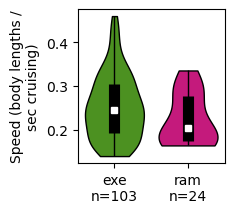

In [86]:
col = 'Speed (body lengths / sec cruising)'# 
df = getDfForCol(col,[path_summaries_df,step_summaries_df,gait_summaries_df])

f,ax = plt.subplots(1,1,figsize=(1.9,2))

# violin plot comparison
ax, data_to_plot = compViolPlot(ax,df,col,[con_color,exp_color],scatter=False)

pval, test = pairwiseStats(data_to_plot)
ax = facecolorPval(ax,pval)
control_n = len(df[df['treatment']==control])
exp_n = len(df[df['treatment']==experimental])
ax.set_xticks([1,2],[control[:3]+'\nn='+str(control_n),experimental[:3]+'\nn='+str(exp_n)]) # comment off if want default ticks
print(test, 'p-val', np.round(pval,4))
plt.show()

In [112]:
# choose 14 exemplaris with speed closest to ram average (b/c ram have 14 with speed)
ram_df = path_summaries_df[path_summaries_df['treatment']=='ramazzottius']
ram_speeds = np.sort(ram_df[col].values)
ram_speeds = gaitFunctions.omitNan(ram_speeds)
ram_ids = ram_df[ram_df[col].isin(ram_speeds)]['Identifier'].values
print(len(ram_ids))
average_ram_speed = np.mean(ram_speeds)

buffer = int(len(ram_speeds)/2) # 14 of the ramazzottius dudes have speed

exe_df = path_summaries_df[path_summaries_df['treatment']=='exemplaris']
exe_speeds = np.sort(exe_df[col].values)
closest_exe_idx = np.where(exe_speeds>=average_ram_speed)[0][0]

closest_exe_speeds = exe_speeds[closest_exe_idx-buffer:closest_exe_idx+buffer]

closest_exe_ids = exe_df[exe_df[col].isin(closest_exe_speeds)]['Identifier'].values
print(len(closest_exe_ids)) # ok, 14

all_slow_ids = np.concatenate((ram_ids, closest_exe_ids))
slow_path_df = path_summaries_df[path_summaries_df['Identifier'].isin(all_slow_ids)]
slow_gait_df = gait_summaries_df[gait_summaries_df['Identifier'].isin(all_slow_ids)]

14
14


Mann-Whitney U p-val 0.3012


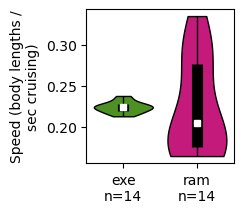

In [120]:
col = 'Speed (body lengths / sec cruising)'

f,ax = plt.subplots(1,1,figsize=(1.9,2))

# violin plot comparison
ax, data_to_plot = compViolPlot(ax,slow_path_df,col,[con_color,exp_color],scatter=False)

pval, test = pairwiseStats(data_to_plot)
ax = facecolorPval(ax,pval)
control_n = len(df[df['treatment']==control])
exp_n = len(df[df['treatment']==experimental])
ax.set_xticks([1,2],[control[:3]+'\nn='+str(len(closest_exe_ids)),experimental[:3]+'\nn='+str(len(ram_ids))]) # comment off if want default ticks
print(test, 'p-val', np.round(pval,4))
plt.show()

28


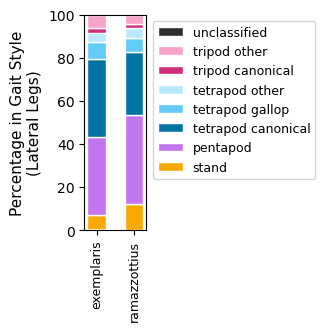

In [122]:
# just the slow ones
print(len(slow_gait_df))
legset='lateral' # lateral or rear
f, ax = plt.subplots(1,1,figsize=(0.8,2.8))
ax = gaitStylePercentagesPlot(ax, slow_gait_df, control, legset, True) # False to hide legend and Y label
plt.show()

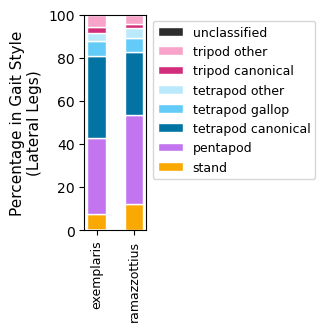

In [123]:
# all of em
f, ax = plt.subplots(1,1,figsize=(0.8,2.8))
ax = gaitStylePercentagesPlot(ax, gait_summaries_df.copy(), control, legset, True) # False to hide legend and Y label
plt.show()